# Learn To Synchronize Videos

## Model declaration

In [1]:
from importlib import reload
import torch
import torch.nn as nn
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import sync_net
import trainer
import metrics
import data_loader
reload(sync_net)
reload(trainer)
reload(metrics)
reload(data_loader)
from sync_net import reset_first_layer, replace_last_layer, add_sigmoid_activation, stop_running_var, freeze_model, TripletNet, MultiSiameseNet, TripletLoss, CosineSimilarityTripletLoss, LosslessTripletLoss, MultiSiameseCosineSimilarityLoss, SoftMultiSiameseCosineSimilarityLoss
from trainer import fit
from metrics import EmbeddingL2DistanceMetric, EmbeddingCosineSimilarityMetric, EmbeddingCosineSimilarityAndDistanceLossMetric
from data_loader import get_image_size_from_model_type, get_datasets, get_test_set, get_multisiamese_datasets, get_soft_multisiamese_datasets
# import wandb
# wandb.init(project="learn-to-synchronize-videos")
cuda = torch.cuda.is_available()

torch.cuda.set_device(0)
# embedding_net = models.mobilenet_v2(pretrained=True)  # models.resnet50(pretrained=True)
model_type = "efficientnet-b0"
embedding_net = EfficientNet.from_pretrained(model_type)
img_size = get_image_size_from_model_type(model_type)
# for key, value in embedding_net.state_dict().items():
#     print(key, value.shape)
#     print("------------------")
# modules = [module for module in embedding_net.modules() if type(module) != nn.Sequential]
# for module in modules:
#     print(module)
#     print("------------------")
# reset_first_layer(embedding_net)
# freeze_model(embedding_net)
replace_last_layer(embedding_net, 64)  # , dropout=0.3838756296018854)
embedding_net.apply(stop_running_var)
# embedding_net = add_sigmoid_activation(embedding_net)  # Use only with LosslessTripletLoss
# model = TripletNet(embedding_net)
model = MultiSiameseNet(embedding_net)
model.cuda(0)
model = nn.DataParallel(model).cuda()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# print([x.requires_grad for x in model.parameters()])
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
# loss_fn = TripletLoss(margin=0.5)
# loss_fn = CosineSimilarityTripletLoss(margin=0.5)
# loss_fn = LosslessTripletLoss()
# loss_fn = MultiSiameseCosineSimilarityLoss()
loss_fn = SoftMultiSiameseCosineSimilarityLoss()
# scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, T_mult=2, eta_min=5e-6, last_epoch=-1)
scheduler = lr_scheduler.StepLR(optimizer, 5, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100
start_epoch = 0
save_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\test"
if not os.path.isdir(save_path):
    os.makedirs(save_path)
# wandb.config.lr = lr
# wandb.config.optimizer = type(optimizer)
# wandb.config.loss_fn = type(loss_fn)
print("loaded")

Loaded pretrained weights for efficientnet-b0
loaded


## Load dataset

### Angio sequence triplets

In [ ]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_datasets(training_path, validation_path)

### Angio sequence multi siamese

In [ ]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_multisiamese_datasets(training_path, validation_path, 1000, 64)

### Angio sequence soft multi siamese

In [4]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_paths = [
#     r'C:\Users\root\Data\Angiographie\ABL-5',
#     r'C:\Users\root\Data\Angiographie\G1',
#     r'C:\Users\root\Data\Angiographie\G18'
]
max_cycles_for_pairs = 2.5
sequence = 3
batch_size = 32
inter_video_pairs = False
use_data_augmentation = False
training_set, validation_set = get_soft_multisiamese_datasets(training_path, validation_paths, max_cycles_for_pairs, sequence, 1000, batch_size, inter_video_pairs, use_data_augmentation, img_size)

105 valid frames [32, 136] @22.0 and contracted at index 43.0, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames [50, 159] @22.5 and contracted at index 60.0, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
109 valid frames [44, 152] @22.0 and contracted at index 46.0, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
76 valid frames [56, 131] @20.0 and contracted at index 34.0, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames [53, 131] @20.0 and contracted at index 36.0, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames [35, 155] @22.0 and contracted at index 68.0, in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames [35, 147] @23.0 and contracted at index 47.0, in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
76 valid frames [33, 108] @18.5 and contracted at index 42.0, in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
82 valid frames [41, 122] @18.0 and c

54 valid frames [31, 84] @14.0 and contracted at index 21.0, in C:\Users\root\Data\Angiographie\MB-12\export\LCA_30RAO
53 valid frames [25, 77] @14.0 and contracted at index 20.0, in C:\Users\root\Data\Angiographie\MB-12\export\LCA_30RAO25CAU
53 valid frames [25, 77] @15.5 and contracted at index 32.0, in C:\Users\root\Data\Angiographie\MB-12\export\LCA_AP
53 valid frames [24, 76] @15.5 and contracted at index 33.5, in C:\Users\root\Data\Angiographie\MB-12\export\LCA_LAT
53 valid frames [19, 71] @14.5 and contracted at index 25.0, in C:\Users\root\Data\Angiographie\MJY-9\export\RCA_AP
54 valid frames [20, 73] @14.5 and contracted at index 23.0, in C:\Users\root\Data\Angiographie\MJY-9\export\RCA_LAT
82 valid frames [41, 122] @18.0 and contracted at index 39.0, in C:\Users\root\Data\Angiographie\P20\export\LCA_-30_0
89 valid frames [37, 125] @17.5 and contracted at index 43.0, in C:\Users\root\Data\Angiographie\P20\export\LCA_0_0
98 valid frames [29, 126] @18.0 and contracted at index 4

Computing pair similarities (39/273)
Computing pair similarities (40/273)
Computing pair similarities (41/273)
Computing pair similarities (42/273)
Computing pair similarities (43/273)
Computing pair similarities (44/273)
Computing pair similarities (45/273)
Computing pair similarities (46/273)
Computing pair similarities (47/273)
Computing pair similarities (48/273)
Computing pair similarities (49/273)
Computing pair similarities (50/273)
Computing pair similarities (51/273)
Computing pair similarities (52/273)
Computing pair similarities (53/273)
Computing pair similarities (54/273)
Computing pair similarities (55/273)
Computing pair similarities (56/273)
Computing pair similarities (57/273)
Computing pair similarities (58/273)
Computing pair similarities (59/273)
Computing pair similarities (60/273)
Computing pair similarities (61/273)
Computing pair similarities (62/273)
Computing pair similarities (63/273)
Computing pair similarities (64/273)
Computing pair similarities (65/273)
C

IndexError: list index out of range

## Load training state

In [ ]:
# load_state_path = save_path + r"\training_state_0.pth"
load_state_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\freeze_after_3_epochs\training_state_2.pth"
print(load_state_path)
state = torch.load(load_state_path)
print(state.keys())

start_epoch = int(state['epoch']) + 1
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])
scheduler.load_state_dict(state['scheduler'])

## Train

In [4]:
torch.cuda.empty_cache()  # Doesn't always work to free the GPU memory

### Angio sequence triplets

In [ ]:
train_loader = DataLoader(training_set, batch_size=20, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=20, shuffle=True, num_workers=4)
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

### Angio sequence multisiamese

In [3]:
train_loader = DataLoader(training_set, batch_size=1, shuffle=False, num_workers=0)
val_loader = DataLoader(validation_set, batch_size=1, shuffle=False, num_workers=0)
metrics = []  # [EmbeddingCosineSimilarityAndDistanceLossMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

Starting Epoch 0
Will sample from train_loader


KeyboardInterrupt: 

3
torch.Size([1, 32, 3, 224, 224])
2
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])


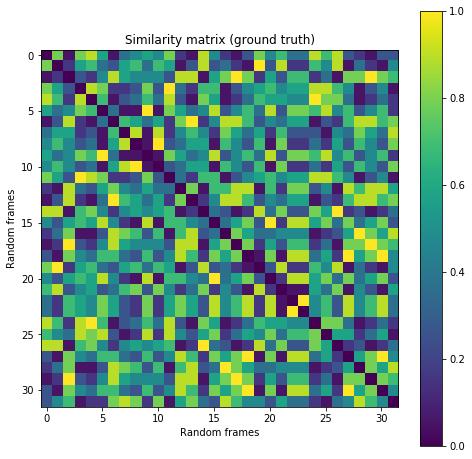

In [33]:
train_loader = DataLoader(training_set, batch_size=1, shuffle=False, num_workers=0)
for batch_idx, data in enumerate(train_loader):
    print(len(data))
    print(data[0].shape)
    print(len(data[1]))
    print(data[1][0].shape)
    print(data[1][1].shape)
    
    figure(figsize=(8,8))
    
#     plt.subplot(1, 2, 1)
    plt.imshow(data[1][0][0])
    plt.colorbar()
    plt.ylabel("Random frames")
    plt.xlabel("Random frames")
    plt.title(f"Similarity matrix (ground truth)")
    
#     plt.subplot(1, 2, 2)
#     plt.imshow(data[1][1][0])
#     plt.ylabel("Frames of video A")
#     plt.xlabel("Frames of video B")
#     plt.title(f"Masks")
    
    plt.show()
    break

## Test trained model

### Load model

In [2]:
test_folder_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\hyperparameter_search\16"
# test_folder_path = save_path
# Find latest model weights in folder
latest_epoch = -1
for file in os.listdir(test_folder_path):
    if ".pth" in file:
        epoch = int(file.split("_")[-1].split(".")[0])
        if epoch > latest_epoch:
            latest_epoch = epoch
load_state_path = test_folder_path + fr"\training_state_{latest_epoch}.pth"

print(load_state_path)
state = torch.load(load_state_path)
model.load_state_dict(state['model'])
model.eval()   

E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\hyperparameter_search\16\training_state_8.pth


DataParallel(
  (module): MultiSiameseNet(
    (embedding_net): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=False)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=False)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1

### Load test set

In [3]:
reload(data_loader)
from data_loader import get_test_set

test_paths = [r'C:\Users\root\Data\Angiographie\AC-1']
# test_paths = [
#     r'C:\Users\root\Data\Angiographie\ABL-5',
#     r'C:\Users\root\Data\Angiographie\G1',
#     r'C:\Users\root\Data\Angiographie\G18'
# ]
test_set = get_test_set(test_paths, img_size)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)

46 valid frames [23, 68] @11.5 and contracted at index 17.0, in C:\Users\root\Data\Angiographie\AC-1\export\LCA_40RA015CAU
49 valid frames [26, 74] @11.5 and contracted at index 29.0, in C:\Users\root\Data\Angiographie\AC-1\export\LCA_45LAO
53 valid frames [31, 83] @11.0 and contracted at index 21.0, in C:\Users\root\Data\Angiographie\AC-1\export\LCA_AP
51 valid frames [33, 83] @11.0 and contracted at index 29.0, in C:\Users\root\Data\Angiographie\AC-1\export\LCA_LAT
69 valid frames [32, 100] @12.0 and contracted at index 32.0, in C:\Users\root\Data\Angiographie\AC-1\export\RCA_AP
66 valid frames [23, 88] @12.0 and contracted at index 29.0, in C:\Users\root\Data\Angiographie\AC-1\export\RCA_LAT
Computing pair similarities (1/6)
Computing pair similarities (2/6)
Computing pair similarities (3/6)
Computing pair similarities (4/6)
Computing pair similarities (5/6)
Computing pair similarities (6/6)


#### Analyze data

In [3]:
sequence_lengths = []
hb_freqs = []
for video_id, video in enumerate(test_loader):
    print(video_id, video[1], video[0].shape)
    sequence_lengths.append(video[0].shape[1])
    hb_freqs.append(test_set.get_hb_freq(video[1][0]))
sequence_lengths = np.array(sequence_lengths)
hb_freqs = np.array(hb_freqs)
print("Average number of frames", sequence_lengths.mean())
print("Standard deviation", sequence_lengths.std())
print("Average heartbeat frequency", hb_freqs.mean())
print("Standard deviation", hb_freqs.std())

0 ('AA-4 LCA_30LAO25CAU',) torch.Size([1, 103, 3, 224, 224])
1 ('AA-4 LCA_30RAO',) torch.Size([1, 108, 3, 224, 224])
2 ('AA-4 LCA_30RAO25CAU',) torch.Size([1, 107, 3, 224, 224])
3 ('AA-4 LCA_AP',) torch.Size([1, 74, 3, 224, 224])
4 ('AA-4 LCA_LAT',) torch.Size([1, 77, 3, 224, 224])
5 ('AA-4 RCA_AP',) torch.Size([1, 119, 3, 224, 224])
6 ('AA-4 RCA_LAT',) torch.Size([1, 111, 3, 224, 224])
7 ('ABL-5 LCA_30LAO25CRA',) torch.Size([1, 74, 3, 224, 224])
8 ('ABL-5 LCA_30RAO',) torch.Size([1, 80, 3, 224, 224])
9 ('ABL-5 LCA_AP',) torch.Size([1, 87, 3, 224, 224])
10 ('ABL-5 LCA_LAT',) torch.Size([1, 91, 3, 224, 224])
11 ('ABL-5 RCA_AP',) torch.Size([1, 38, 3, 224, 224])
12 ('ABL-5 RCA_LAT',) torch.Size([1, 38, 3, 224, 224])
13 ('AC-1 LCA_40RA015CAU',) torch.Size([1, 44, 3, 224, 224])
14 ('AC-1 LCA_45LAO',) torch.Size([1, 47, 3, 224, 224])
15 ('AC-1 LCA_AP',) torch.Size([1, 51, 3, 224, 224])
16 ('AC-1 LCA_LAT',) torch.Size([1, 49, 3, 224, 224])
17 ('AC-1 RCA_AP',) torch.Size([1, 67, 3, 224, 224])

### Compute distance and similarity matrices for each video

Batch 1/6 (AC-1 LCA_40RA015CAU) with 44 sequences


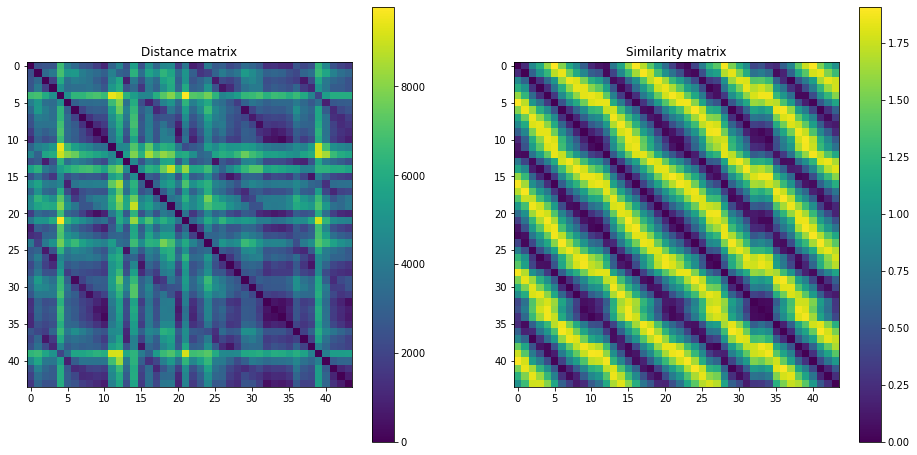

Batch 2/6 (AC-1 LCA_45LAO) with 47 sequences


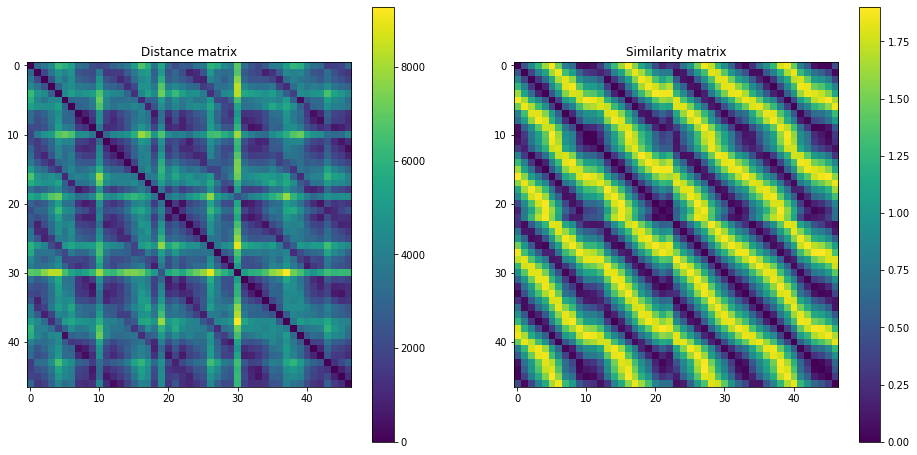

Batch 3/6 (AC-1 LCA_AP) with 51 sequences


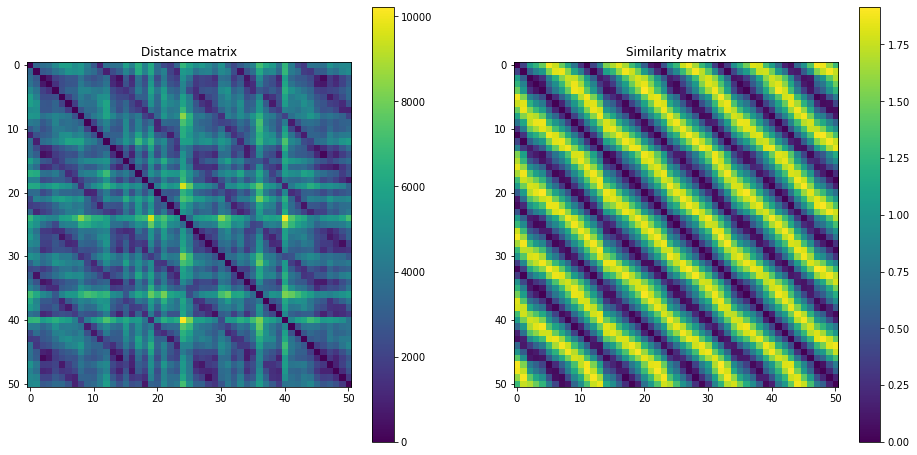

Batch 4/6 (AC-1 LCA_LAT) with 49 sequences


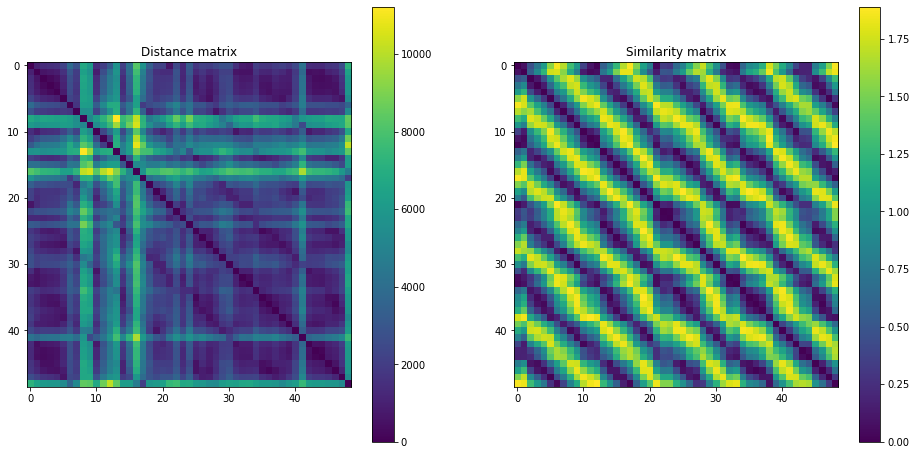

Batch 5/6 (AC-1 RCA_AP) with 67 sequences


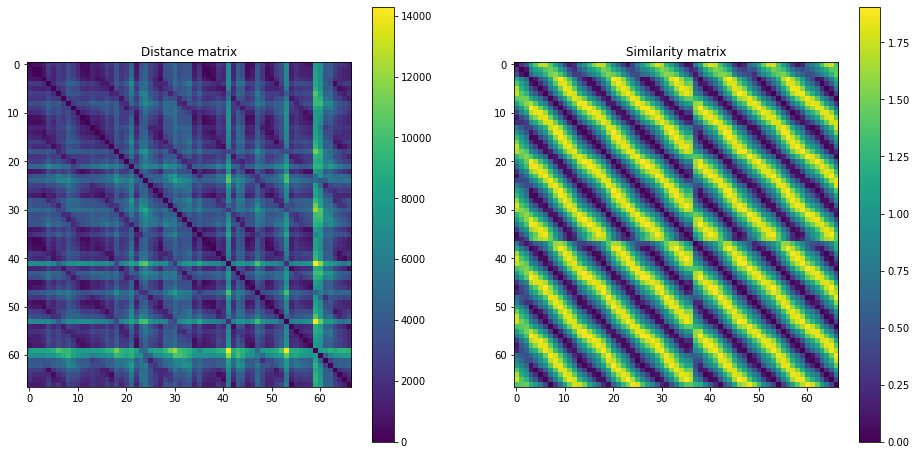

Batch 6/6 (AC-1 RCA_LAT) with 64 sequences


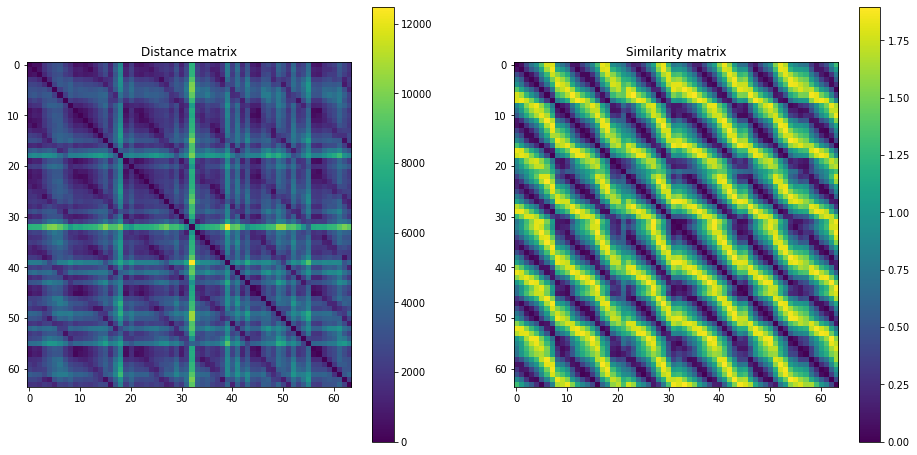

In [4]:
def calc_distance_and_similarity_matrices(embeddings):
    distances = []
    similarities = []
    for i in range(len(embeddings)):
        distances_i = []
        similarities_i = []
        for j in range(len(embeddings)):
            if j < i:
                distances_i.append(distances[j][i])
                similarities_i.append(similarities[j][i])
            elif j == i:
                distances_i.append(0)
                similarities_i.append(0)
            else:
                # Distance
                dist_val = torch.sum(torch.abs(embeddings[i] - embeddings[j]))
                distances_i.append(dist_val.cpu().numpy())
                # Similarity
                normalized_embedding_i = embeddings[i] / torch.norm(embeddings[i])
                normalized_embedding_j = embeddings[j] / torch.norm(embeddings[j])
                sim_val = 1 - normalized_embedding_i.dot(normalized_embedding_j)
                similarities_i.append(sim_val.cpu().numpy())
        distances.append(distances_i)
        similarities.append(similarities_i)
    distances = np.array(distances)
    similarities = np.array(similarities)
    return distances, similarities

with torch.no_grad():
    all_embeddings = []
    names = []
    for batch_index, sequences in enumerate(test_loader):
        name = sequences[1][0]
        sequences = sequences[0]
        
        # sequences: (batch, video_frame, channel, width, height)
        print(f"Batch {batch_index + 1}/{len(test_loader)} ({name}) with {len(sequences[0])} sequences")
        embeddings = model(sequences[0])
        all_embeddings.append(embeddings)
        names.append(name)
        
        distance_matrix, similarity_matrix = calc_distance_and_similarity_matrices(embeddings)
        
        figure(figsize=(16,8))
        
        plt.subplot(1, 2, 1)
        plt.imshow(distance_matrix)
        plt.colorbar()
        plt.title(f"Distance matrix")
        
        plt.subplot(1, 2, 2)
        plt.imshow(similarity_matrix)
        plt.colorbar()
        plt.title(f"Similarity matrix")
        
        plt.show()

### Compute distance and similarity matrices for video comparison

Combinations of AC-1
Comparison of AC-1 LCA_40RA015CAU and AC-1 LCA_40RA015CAU


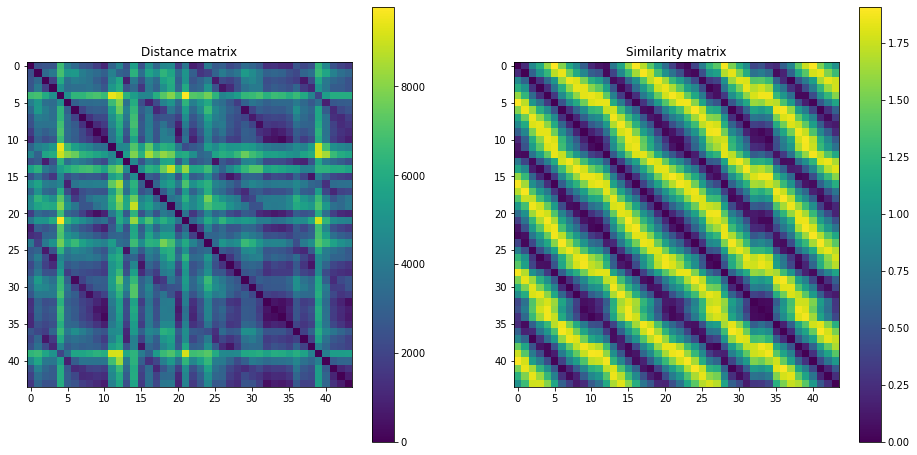

Comparison of AC-1 LCA_40RA015CAU and AC-1 LCA_45LAO


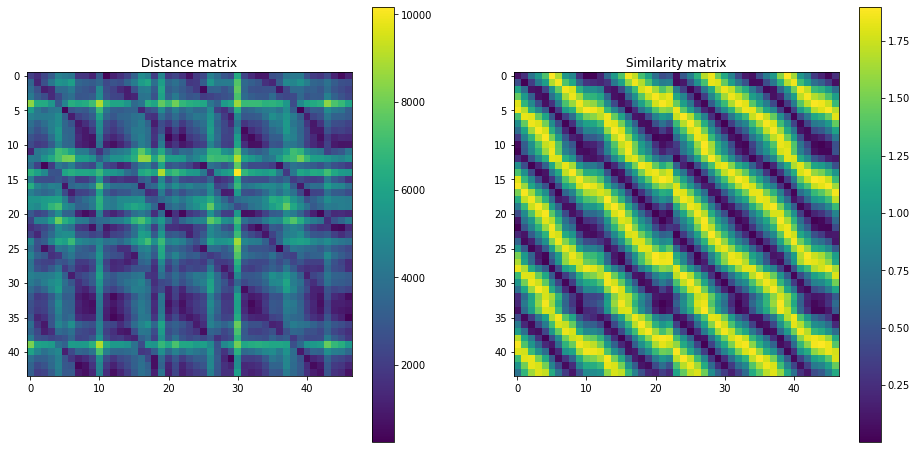

Comparison of AC-1 LCA_40RA015CAU and AC-1 LCA_AP


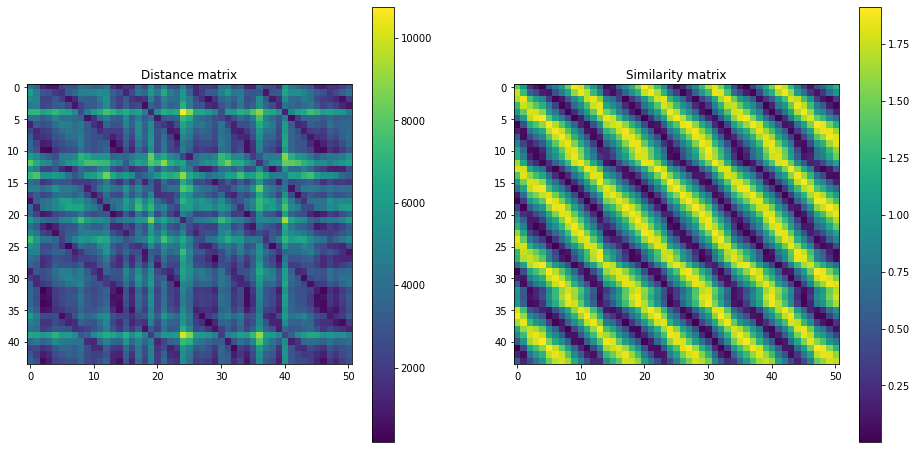

Comparison of AC-1 LCA_40RA015CAU and AC-1 LCA_LAT


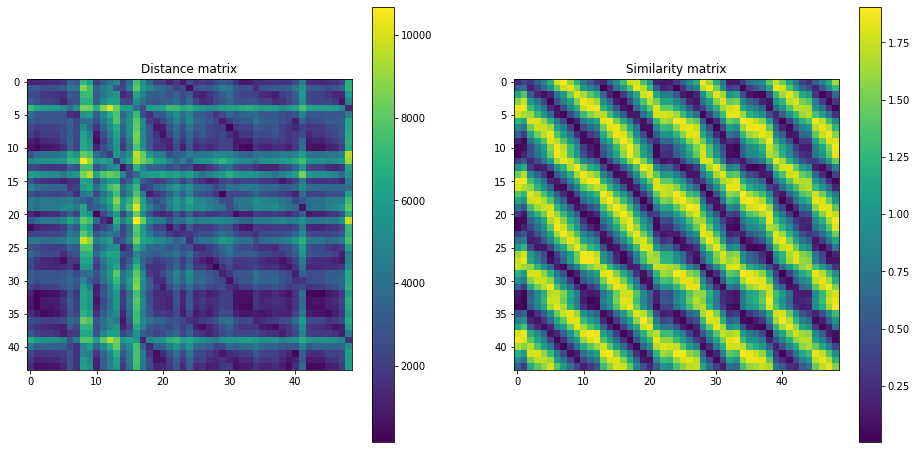

Comparison of AC-1 LCA_40RA015CAU and AC-1 RCA_AP


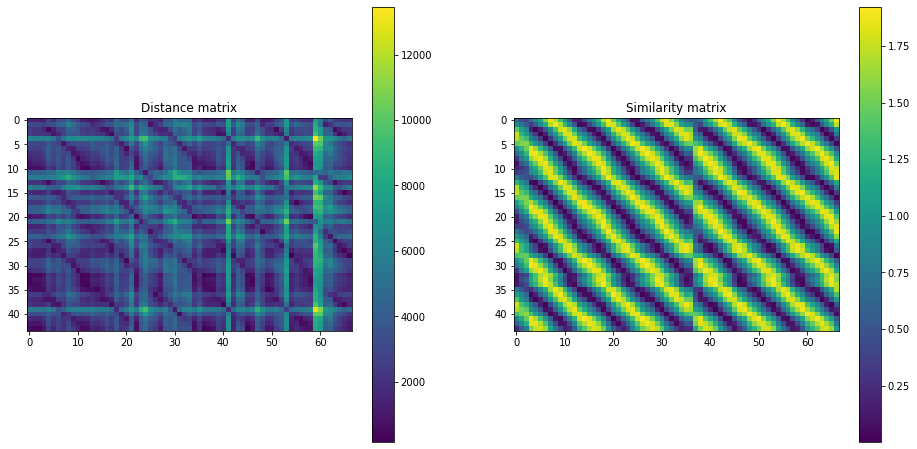

Comparison of AC-1 LCA_40RA015CAU and AC-1 RCA_LAT


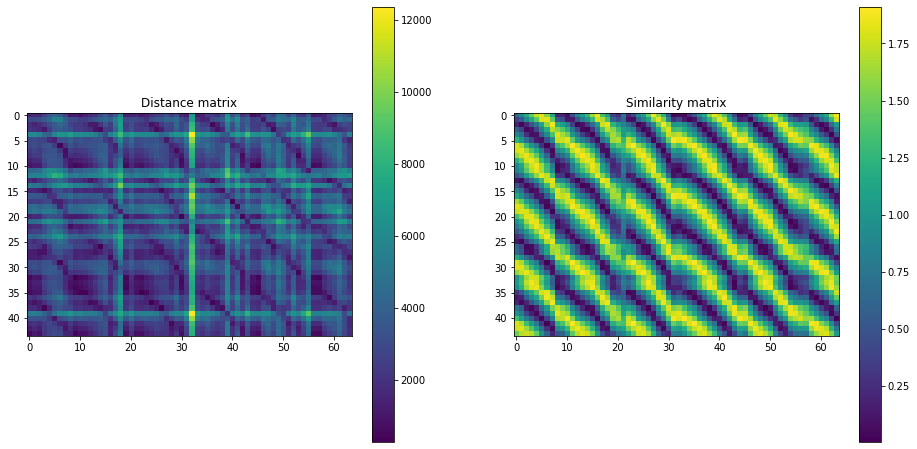

Comparison of AC-1 LCA_45LAO and AC-1 LCA_45LAO


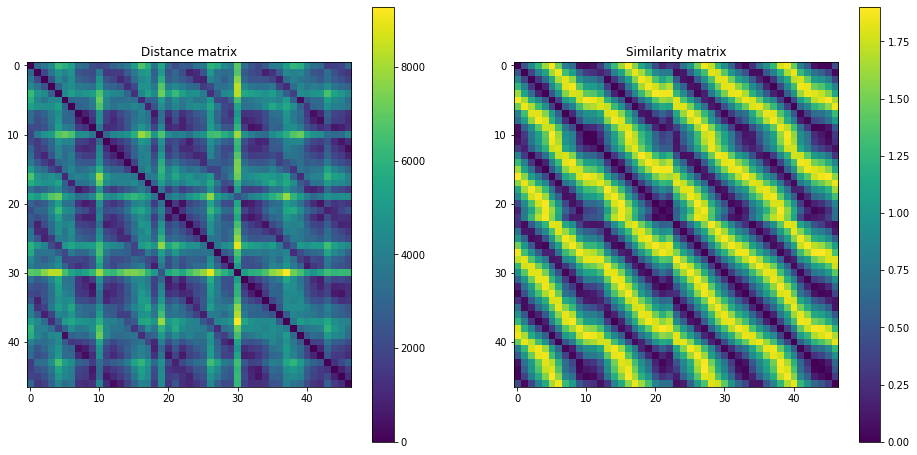

Comparison of AC-1 LCA_45LAO and AC-1 LCA_AP


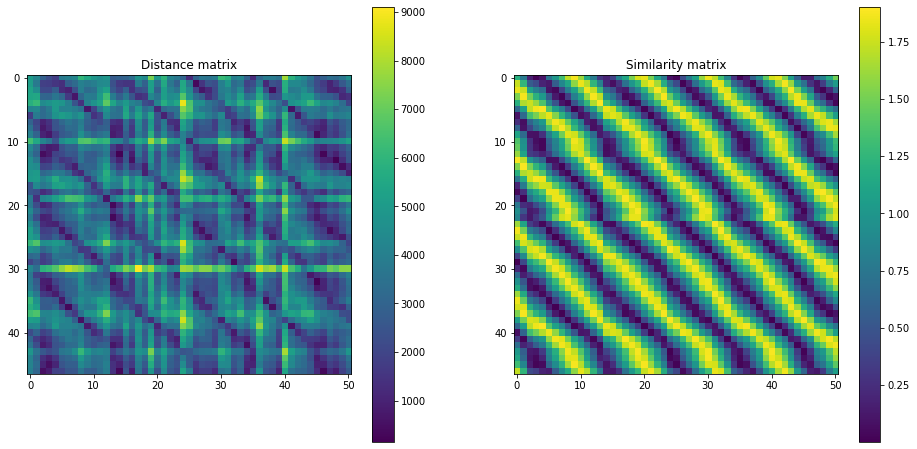

Comparison of AC-1 LCA_45LAO and AC-1 LCA_LAT


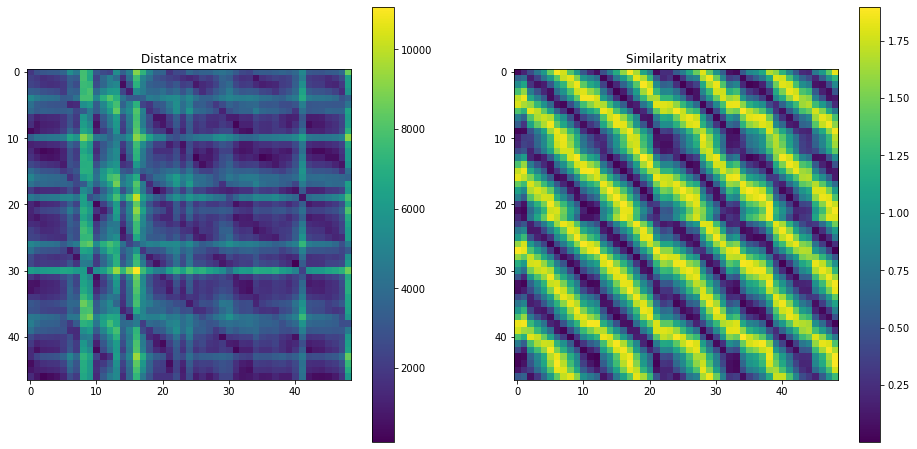

Comparison of AC-1 LCA_45LAO and AC-1 RCA_AP


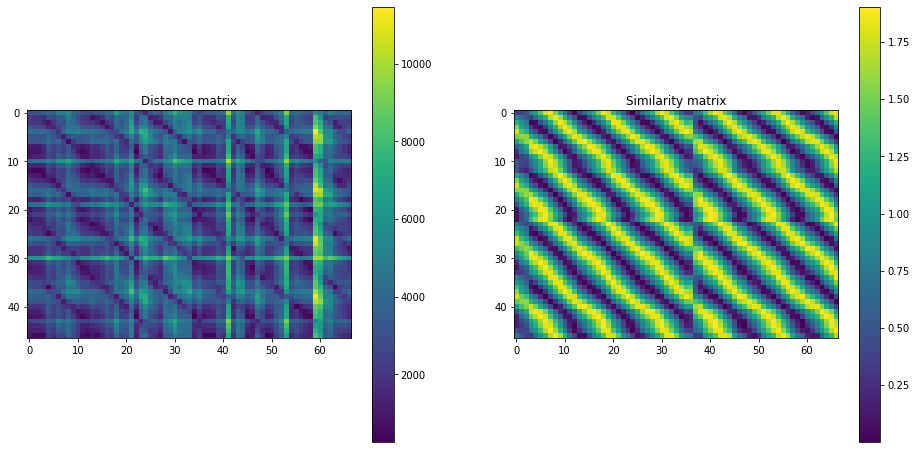

Comparison of AC-1 LCA_45LAO and AC-1 RCA_LAT


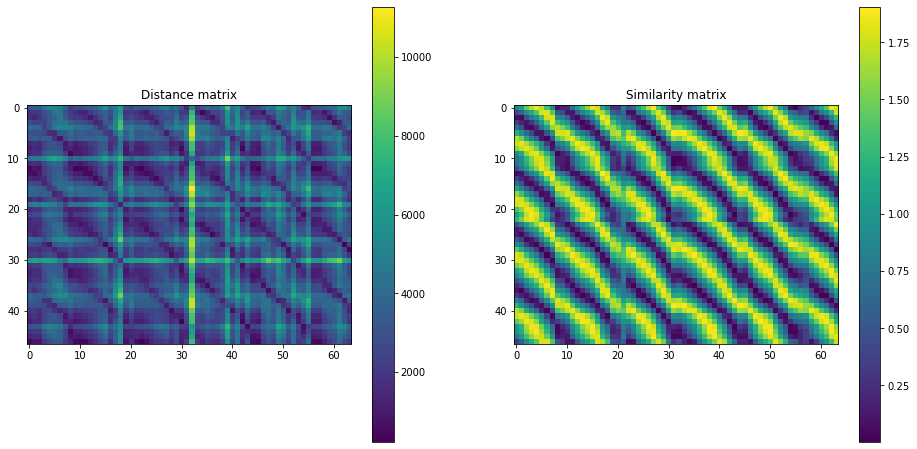

Comparison of AC-1 LCA_AP and AC-1 LCA_AP


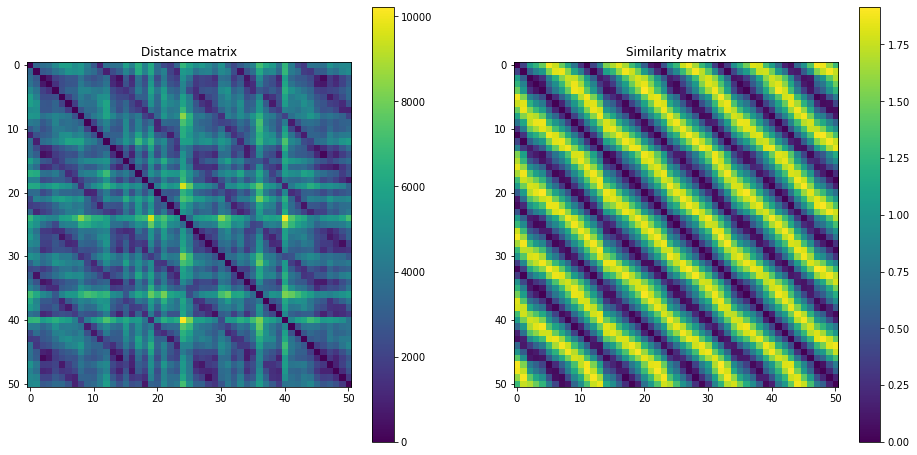

Comparison of AC-1 LCA_AP and AC-1 LCA_LAT


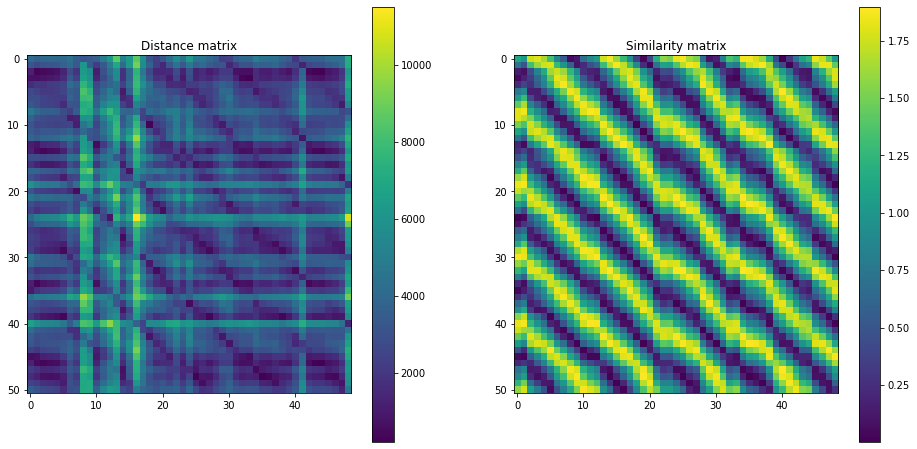

Comparison of AC-1 LCA_AP and AC-1 RCA_AP


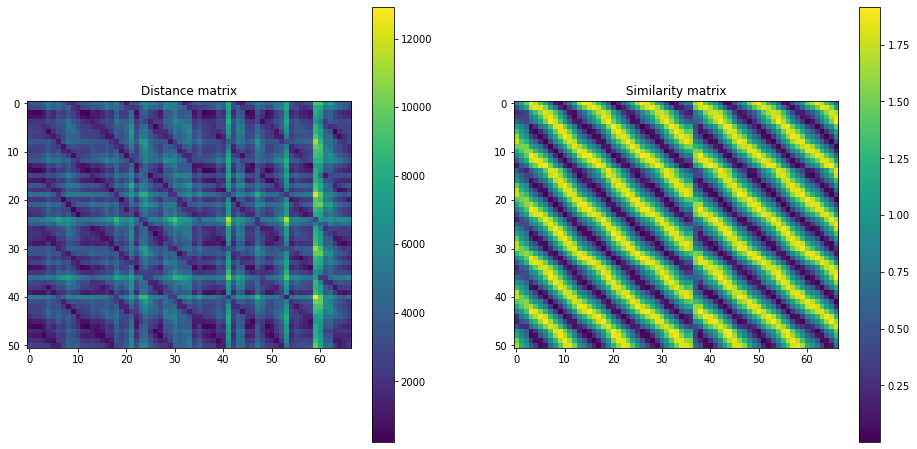

Comparison of AC-1 LCA_AP and AC-1 RCA_LAT


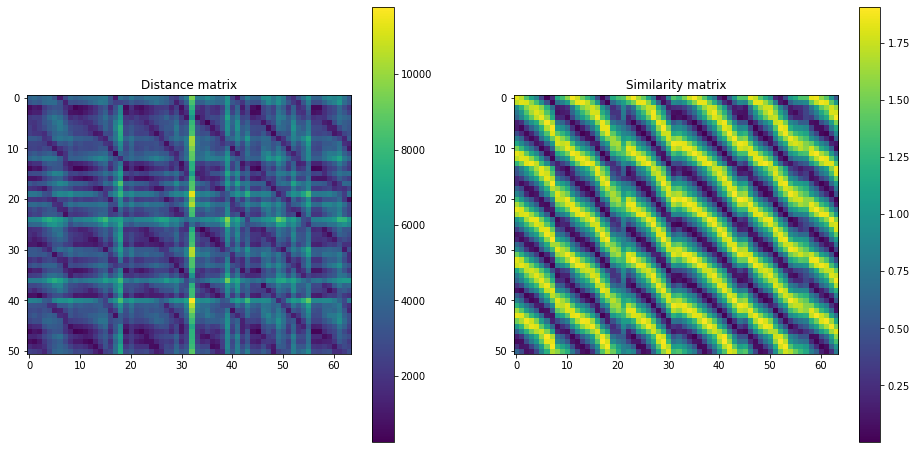

Comparison of AC-1 LCA_LAT and AC-1 LCA_LAT


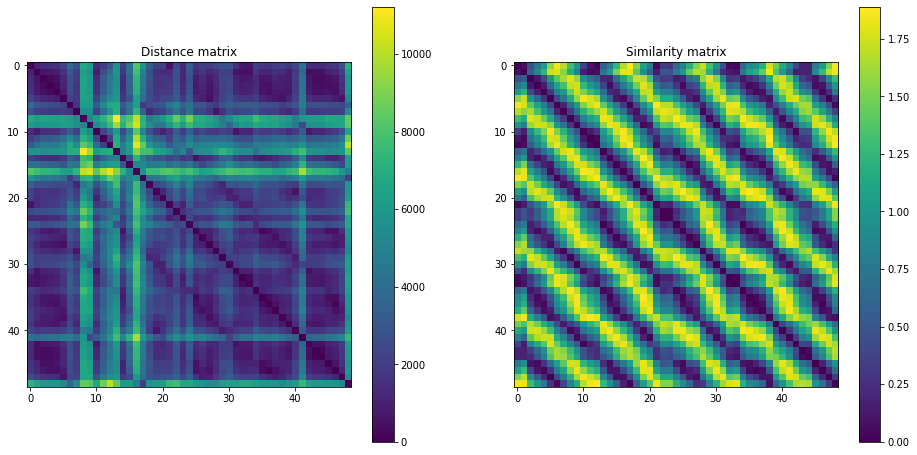

Comparison of AC-1 LCA_LAT and AC-1 RCA_AP


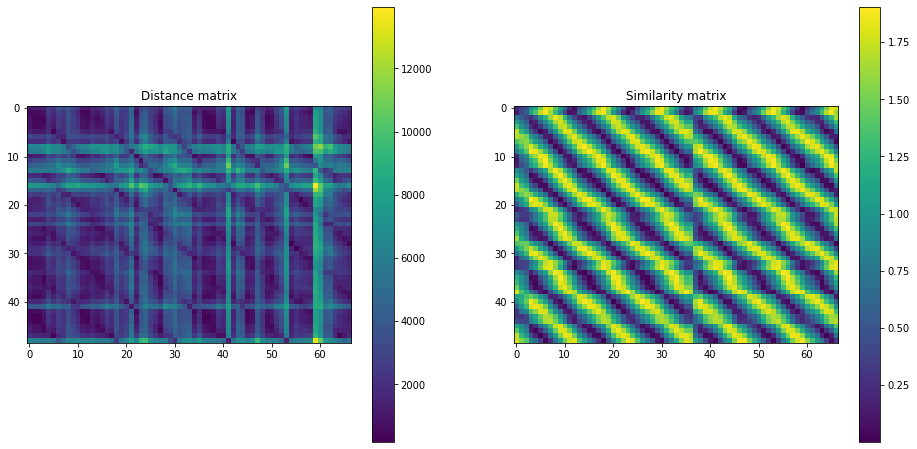

Comparison of AC-1 LCA_LAT and AC-1 RCA_LAT


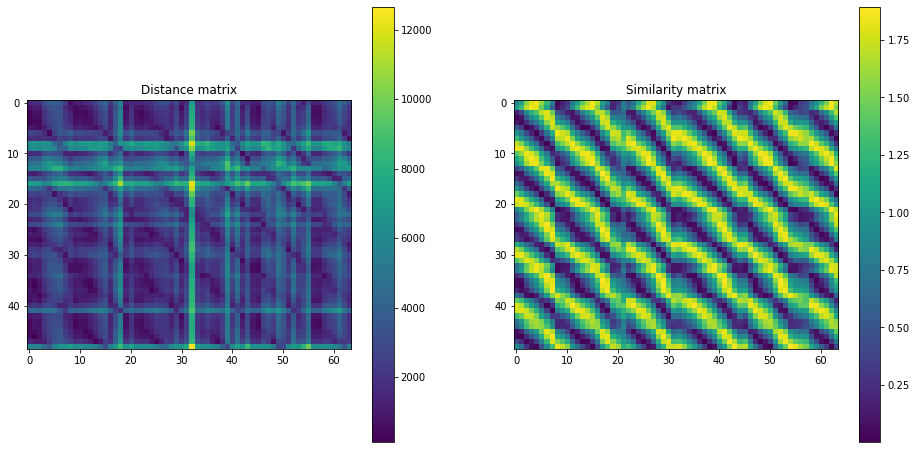

Comparison of AC-1 RCA_AP and AC-1 RCA_AP


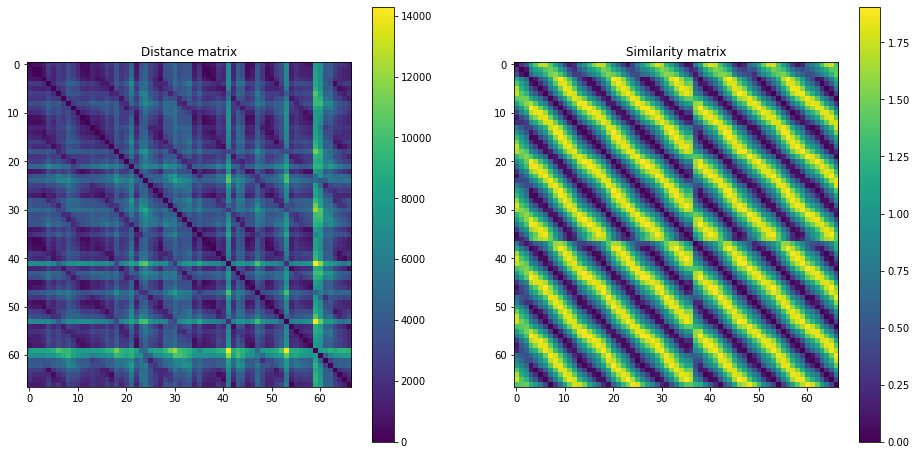

Comparison of AC-1 RCA_AP and AC-1 RCA_LAT


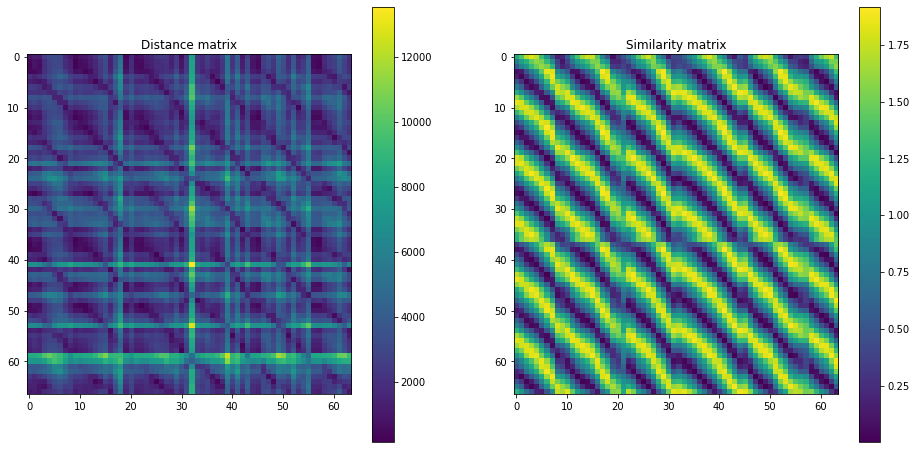

Comparison of AC-1 RCA_LAT and AC-1 RCA_LAT


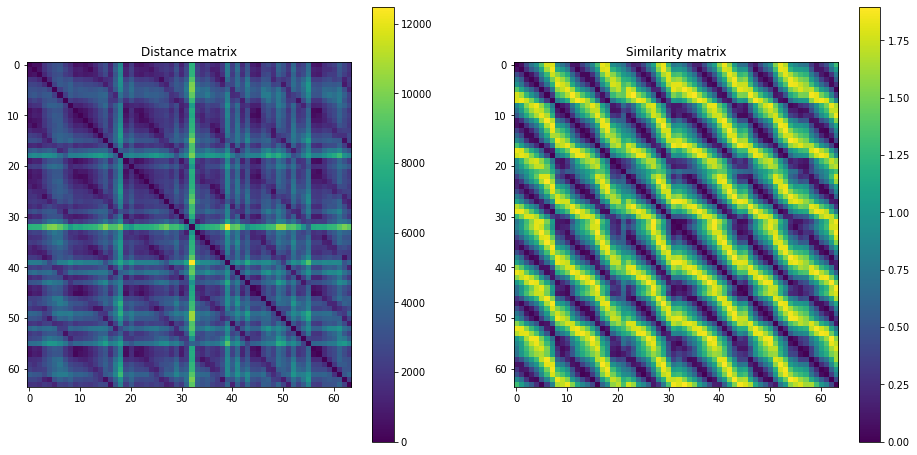

In [5]:
def calc_distance_and_similarity_matrices2(embeddings1, embeddings2):
    distances = []
    similarities = []
    for i in range(len(embeddings1)):
        distances_i = []
        similarities_i = []
        for j in range(len(embeddings2)):
            # Distance
            dist_val = torch.sum(torch.abs(embeddings1[i] - embeddings2[j]))
            distances_i.append(dist_val.cpu().numpy())
            # Similarity
            normalized_embedding_i = embeddings1[i] / torch.norm(embeddings1[i])
            normalized_embedding_j = embeddings2[j] / torch.norm(embeddings2[j])
            sim_val = 1 - normalized_embedding_i.dot(normalized_embedding_j)
            similarities_i.append(sim_val.cpu().numpy())
        distances.append(distances_i)
        similarities.append(similarities_i)
    distances = np.array(distances)
    similarities = np.array(similarities)
    return distances, similarities

with torch.no_grad():
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)
    try:
        all_embeddings
    except NameError:
        all_embeddings = []
        compute_embeddings = True
    else:
        compute_embeddings = False
    if compute_embeddings:
        print (f"Computing embeddings")
        names = []
        for batch_index, sequences in enumerate(test_loader):
            name = sequences[1][0]
            sequences = sequences[0]

            # sequences: (batch, video_frame, channel, width, height)
            print(f"Batch {batch_index + 1}/{len(test_loader)} ({name}) with {len(sequences[0])} sequences")
            embeddings = model(sequences[0])
            all_embeddings.append(embeddings)
            names.append(name)
    
    distance_matrices = {}
    similarity_matrices = {}
    current_name = None
    for i in range(len(all_embeddings)):
        name_i = names[i].split(' ')[0]
        if not name_i == current_name:
            print(f"Combinations of {name_i}")
        distance_matrices[names[i]] = {}
        similarity_matrices[names[i]] = {}
        current_name = name_i
        for j in range(i, len(all_embeddings)):
            if name_i == names[j].split(' ')[0]:
                print(f"Comparison of {names[i]} and {names[j]}")
                distance_matrix, similarity_matrix = calc_distance_and_similarity_matrices2(all_embeddings[i], all_embeddings[j])
                distance_matrices[names[i]][names[j]] = distance_matrix
                similarity_matrices[names[i]][names[j]] = similarity_matrix
                
                figure(figsize=(16,8))

                plt.subplot(1, 2, 1)
                plt.imshow(distance_matrix)
                plt.colorbar()
                plt.title(f"Distance matrix")

                plt.subplot(1, 2, 2)
                plt.imshow(similarity_matrix)
                plt.colorbar()
                plt.title(f"Similarity matrix")

                plt.show()

## Pathfinding

distance_matrix (44, 44)
ground_truth (44, 44)


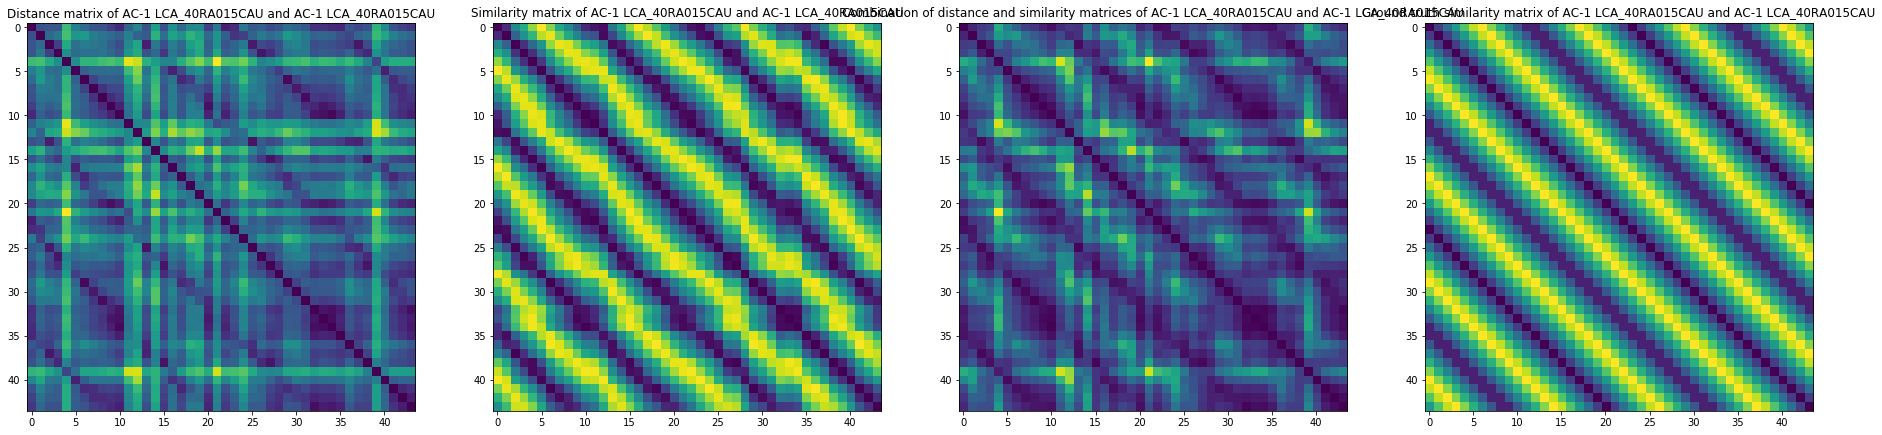

Mean score: 0.920807453416149 for 112 scores


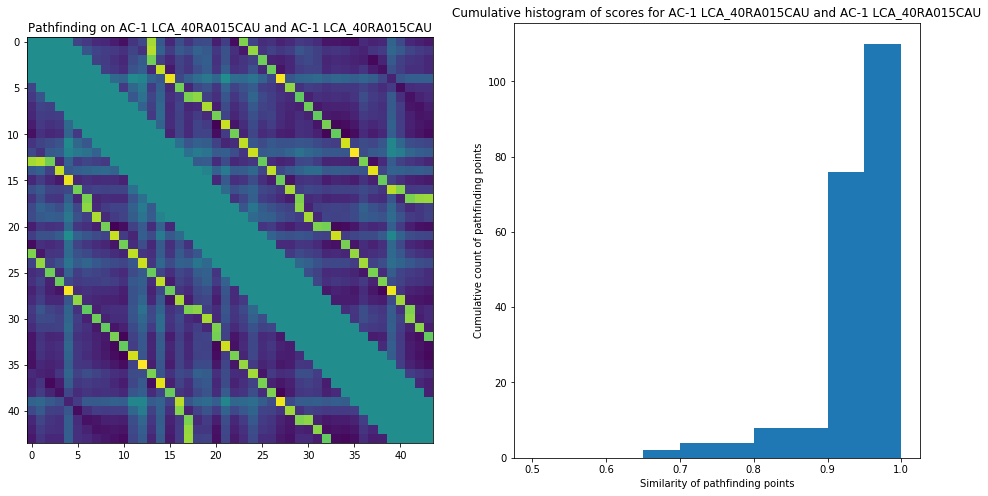

Mean score: 0.9325337331334332 for 116 scores


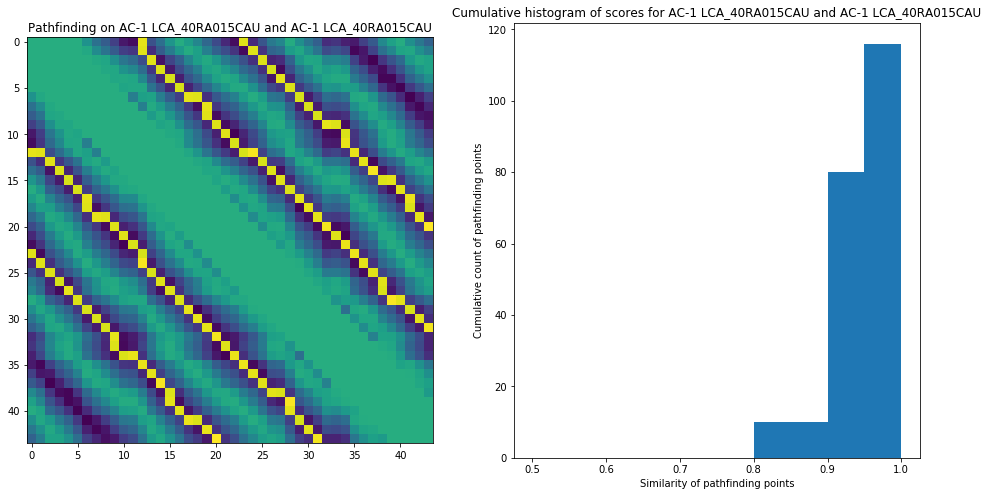

Mean score: 0.9176201372997711 for 114 scores


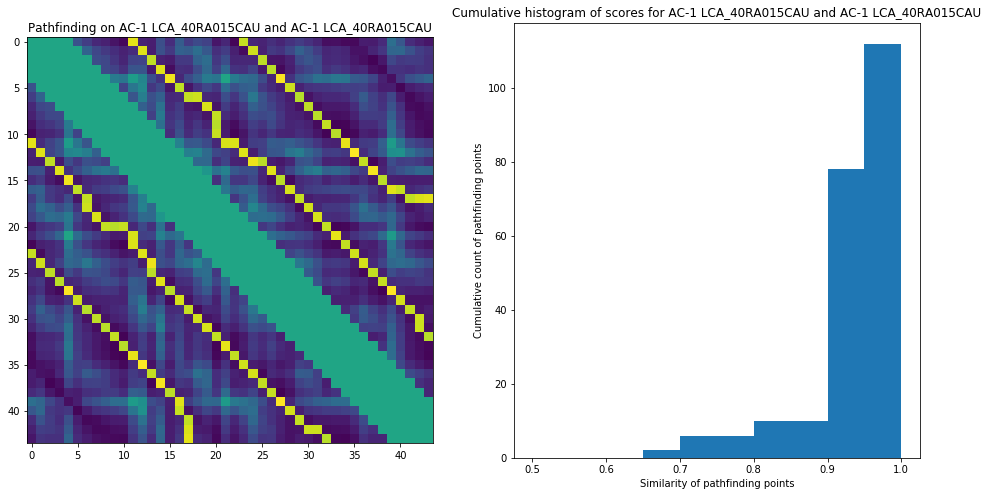

distance_matrix (44, 47)
ground_truth (44, 47)


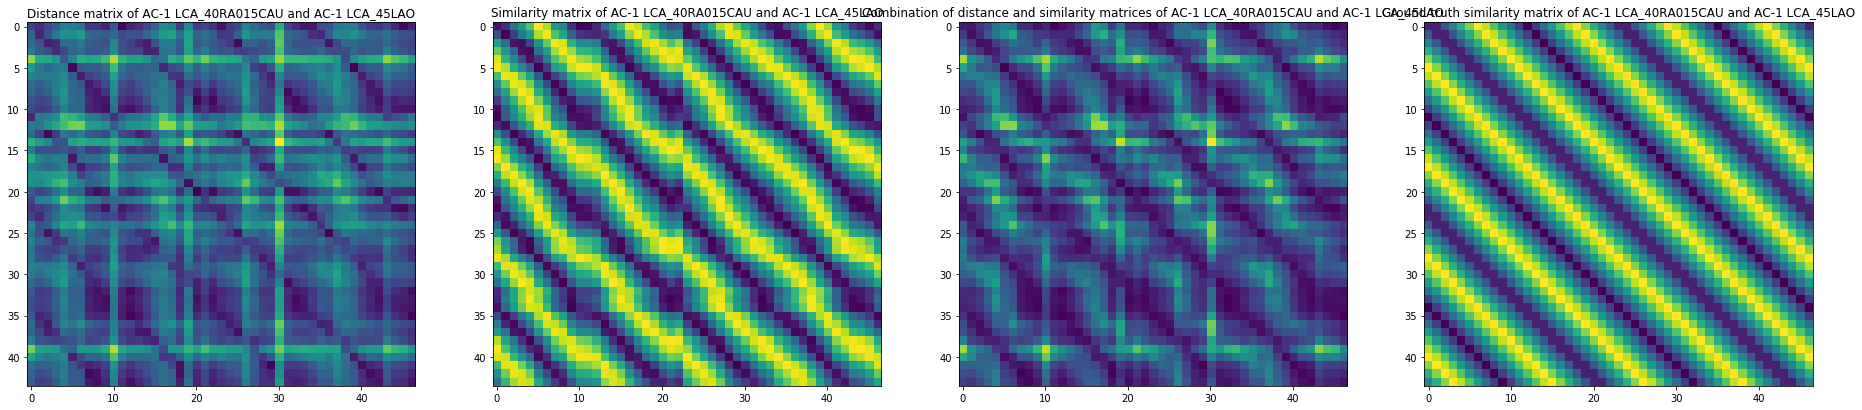

Mean score: 0.8629638060550874 for 191 scores


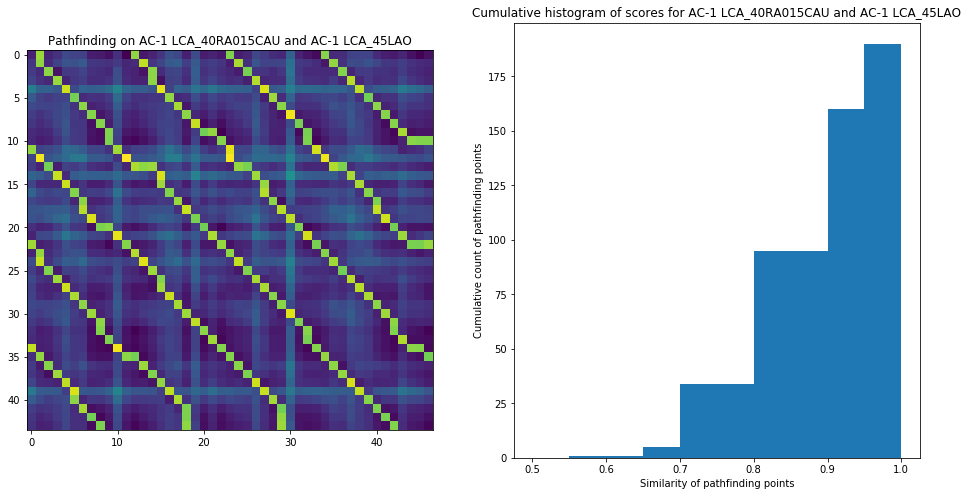

Mean score: 0.8623188405797101 for 192 scores


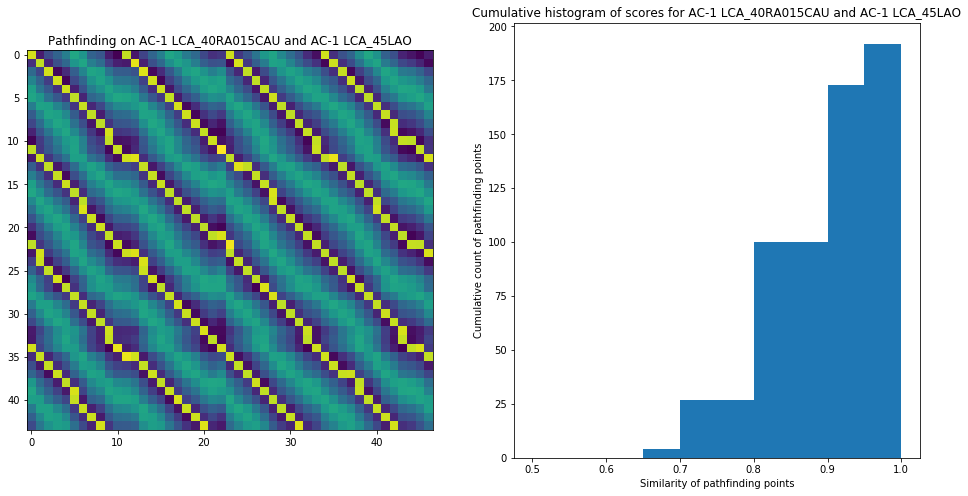

Mean score: 0.8564311594202897 for 192 scores


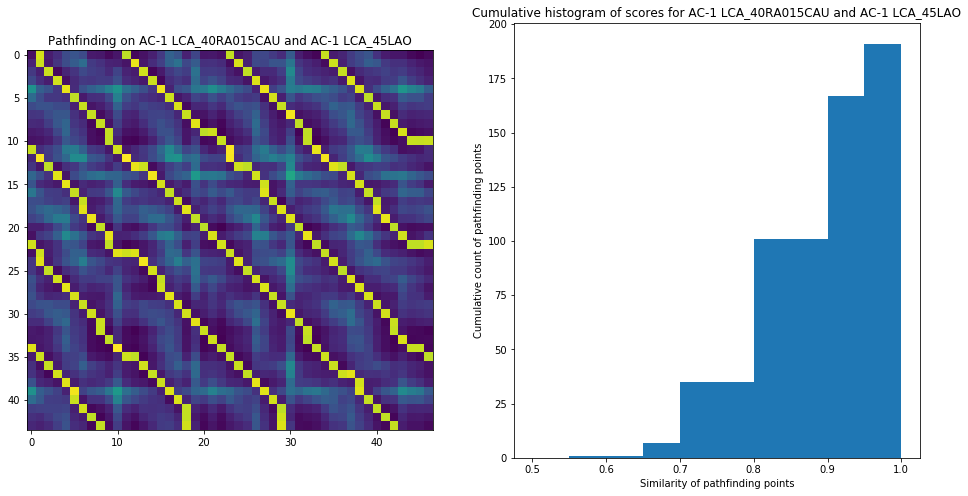

distance_matrix (44, 51)
ground_truth (44, 51)


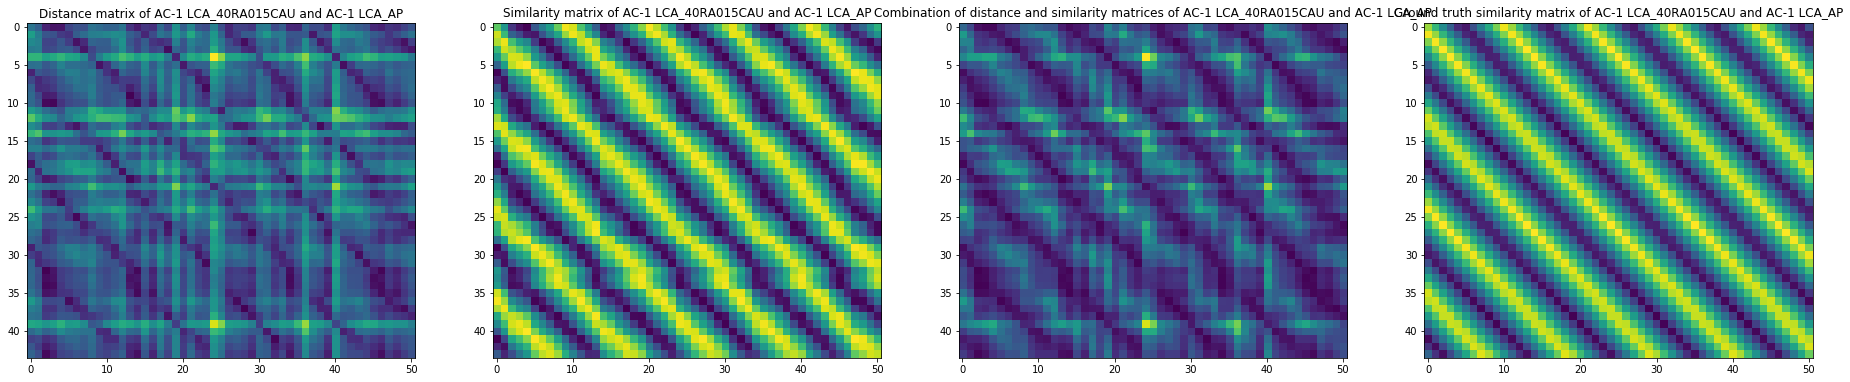

Mean score: 0.8189503732981994 for 216 scores


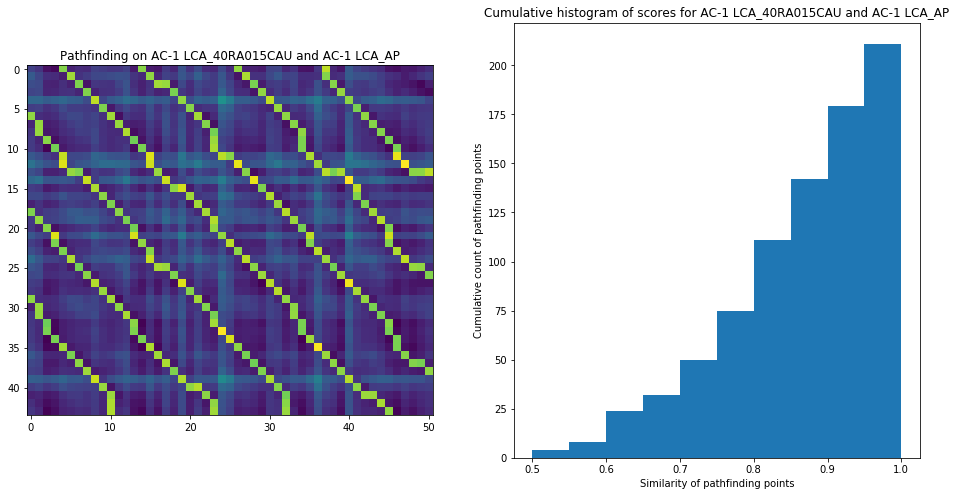

Mean score: 0.8182906044892483 for 218 scores


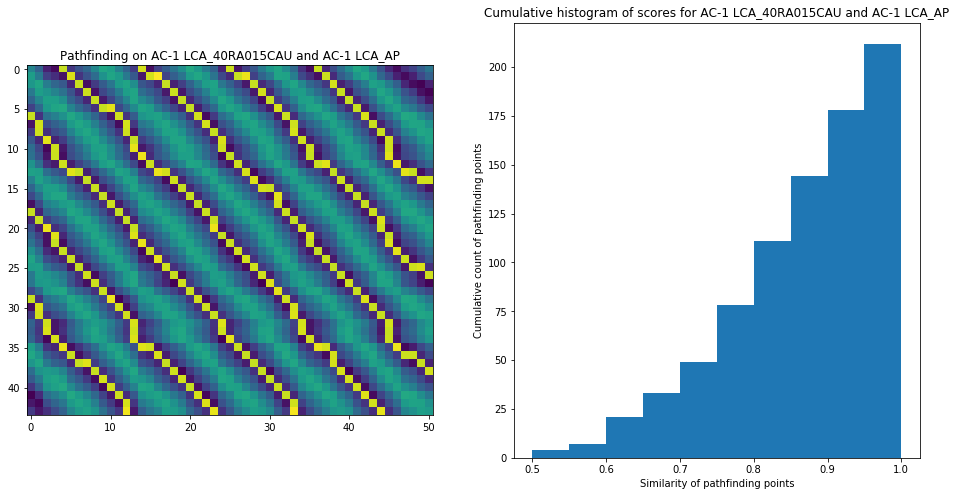

Mean score: 0.8183648074952422 for 216 scores


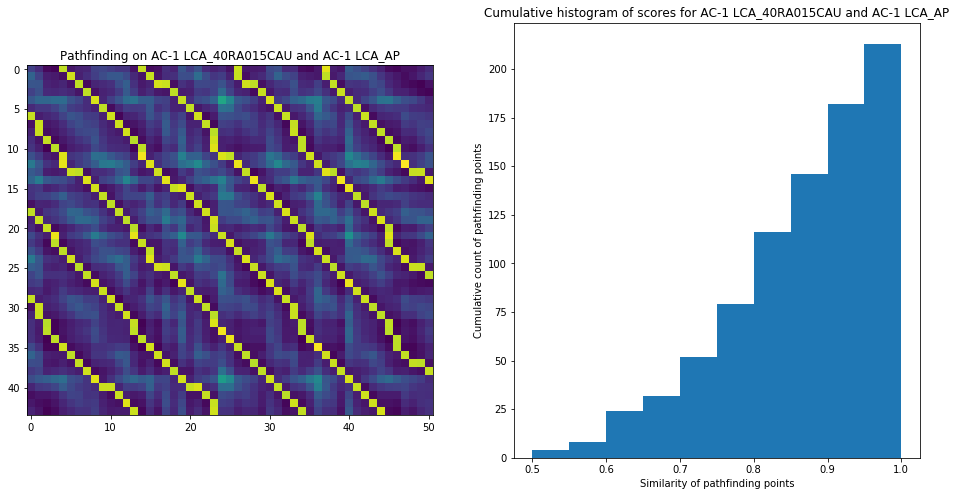

distance_matrix (44, 49)
ground_truth (44, 49)


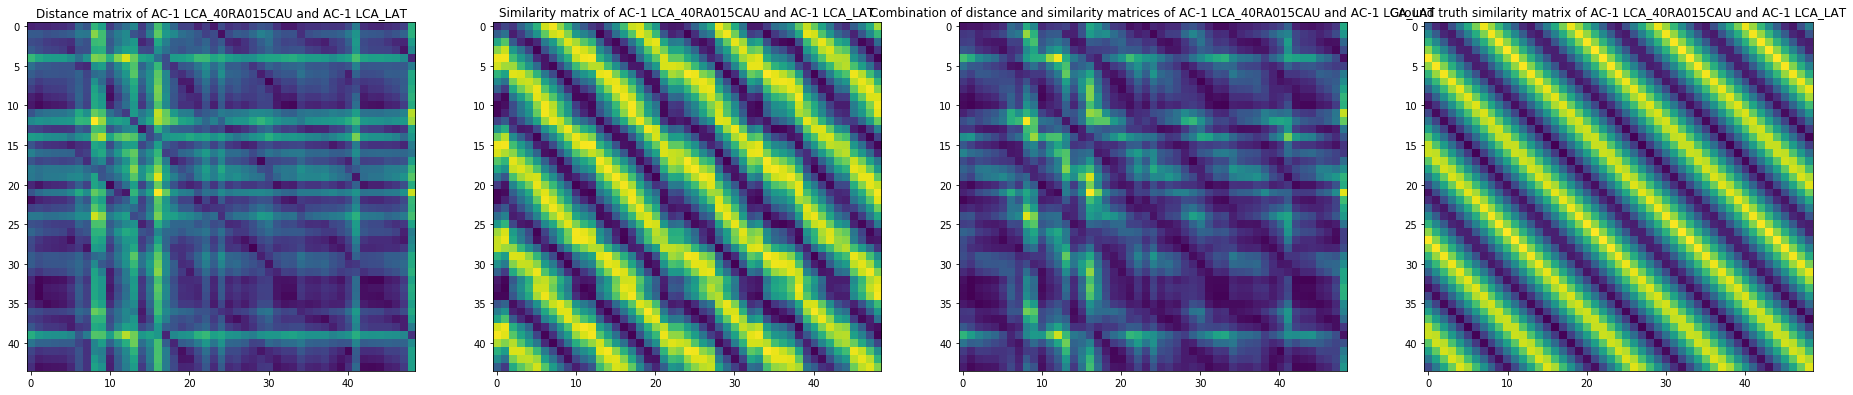

Mean score: 0.8620088351546152 for 204 scores


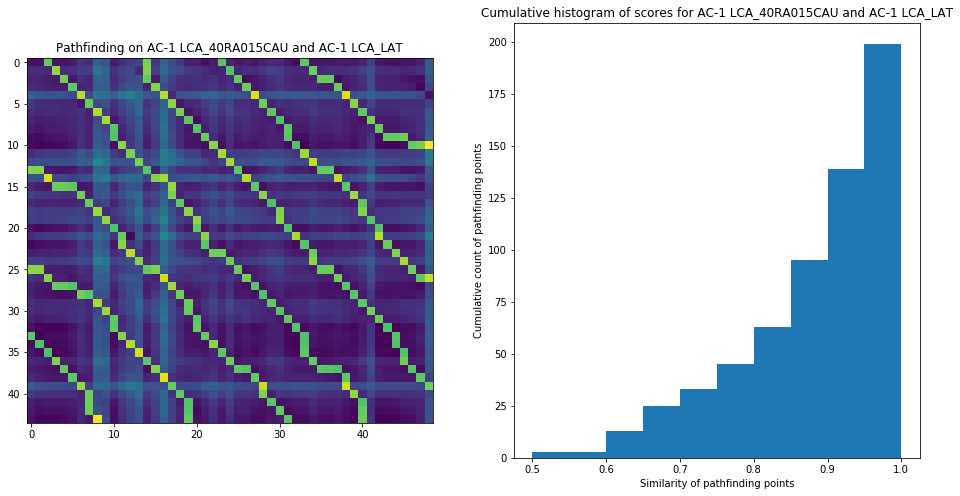

Mean score: 0.8841311667398624 for 216 scores


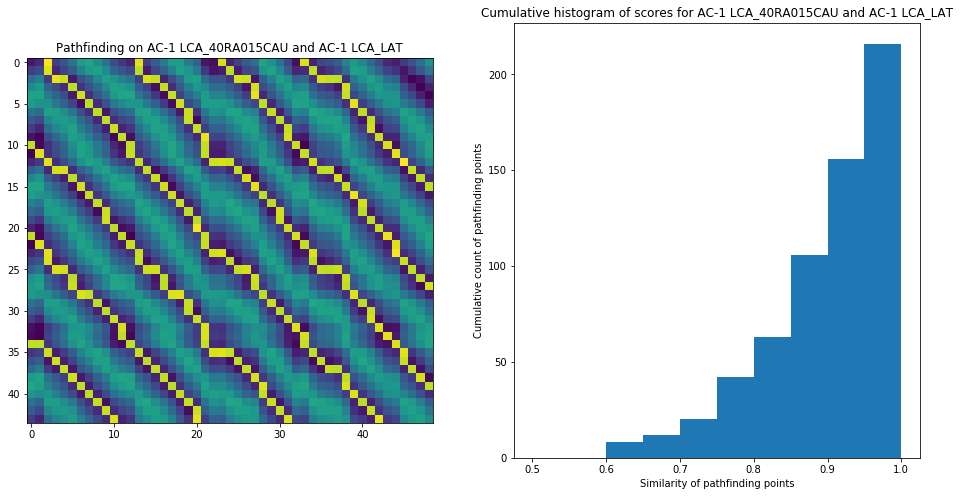

Mean score: 0.8879598662207357 for 208 scores


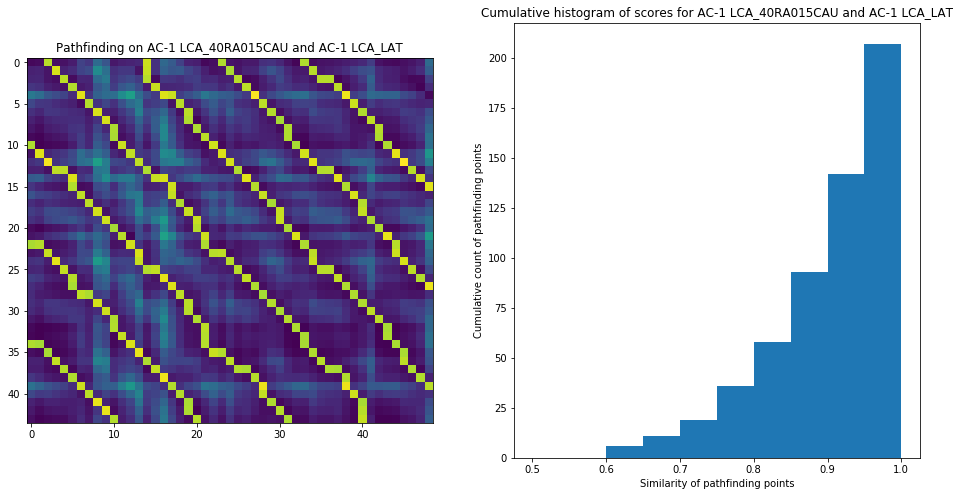

distance_matrix (44, 67)
ground_truth (44, 67)


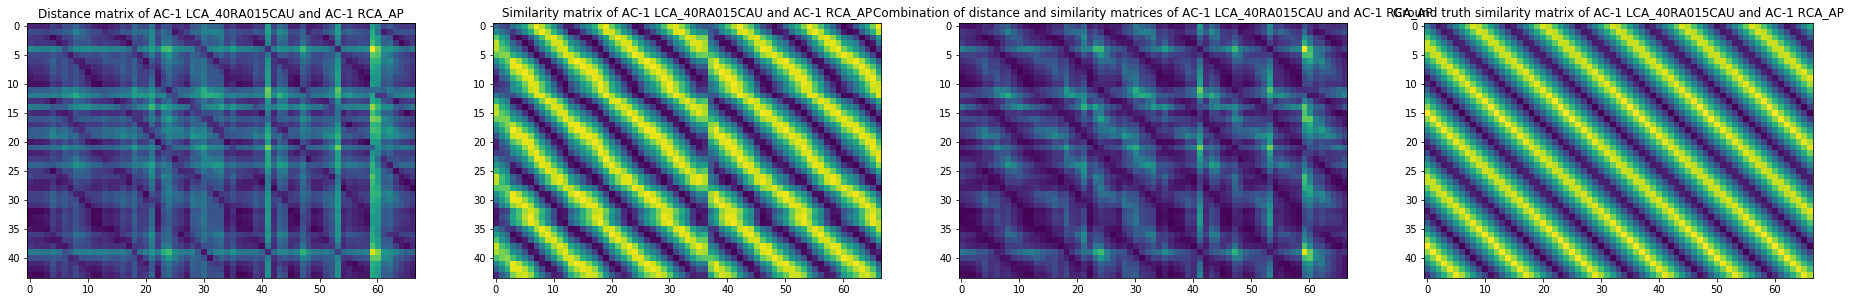

Mean score: 0.7980895915678525 for 220 scores


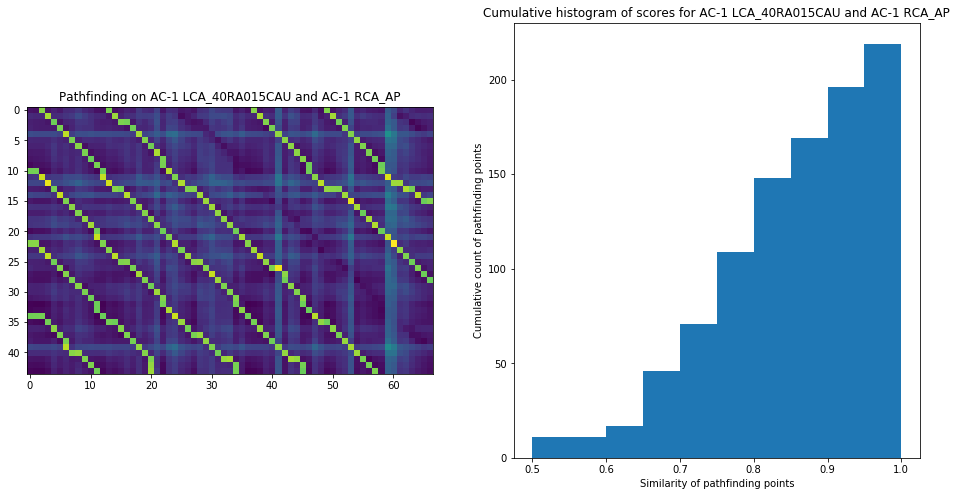

Mean score: 0.786028334147533 for 267 scores


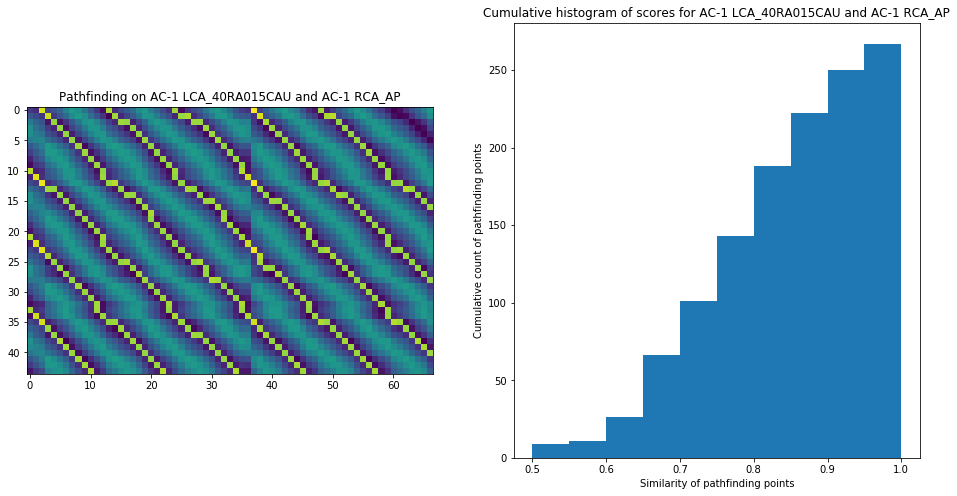

Mean score: 0.7870231550891221 for 261 scores


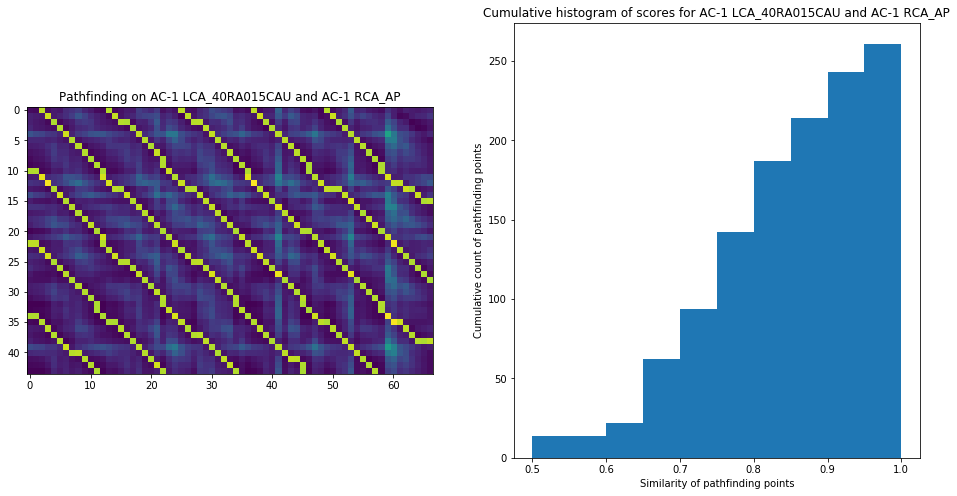

distance_matrix (44, 64)
ground_truth (44, 64)


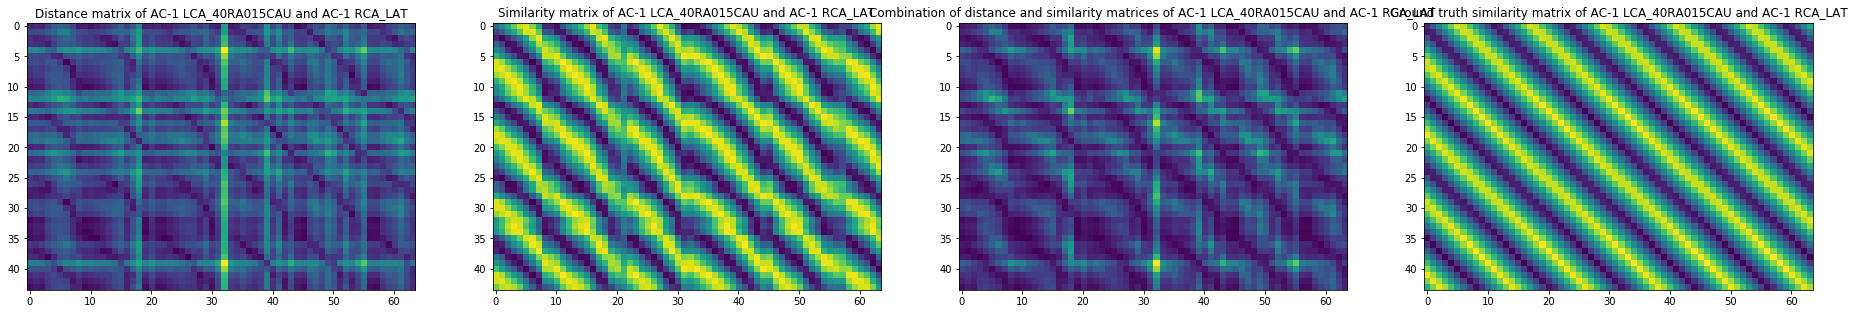

Mean score: 0.7405273266980967 for 249 scores


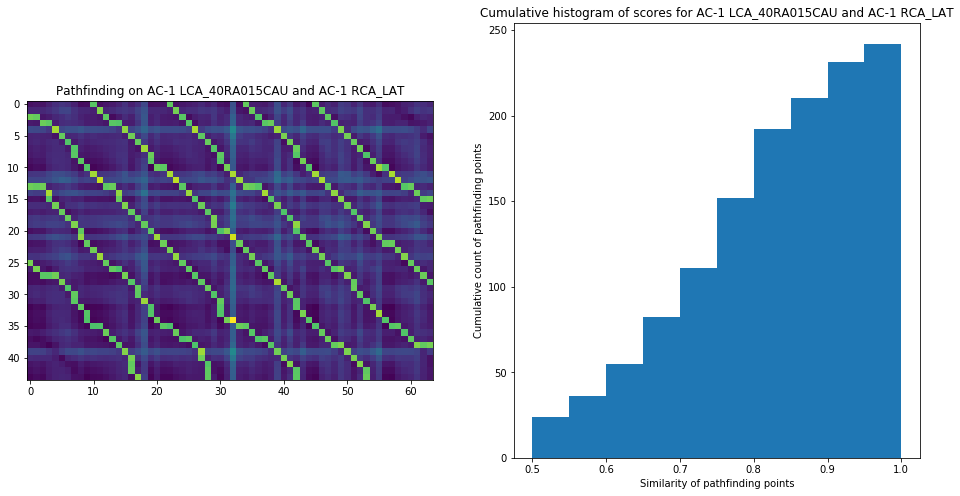

Mean score: 0.7037726273050245 for 257 scores


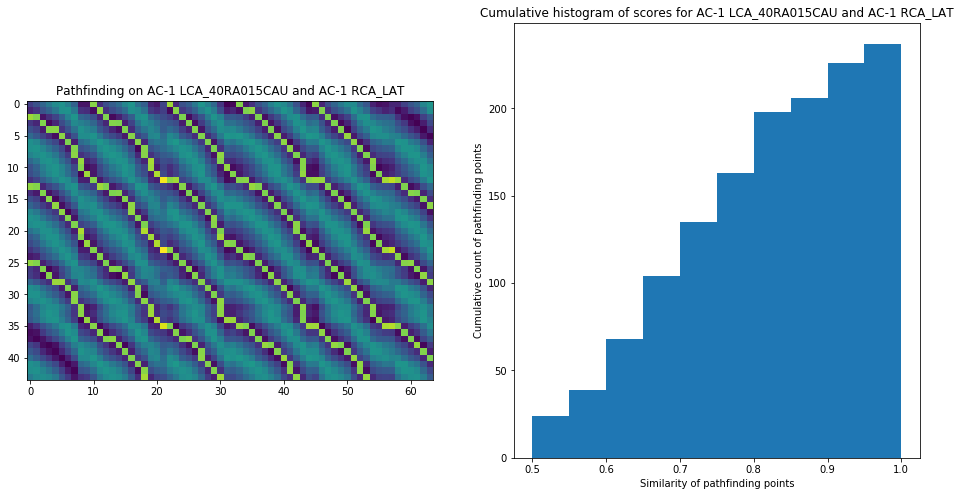

Mean score: 0.7311827956989246 for 248 scores


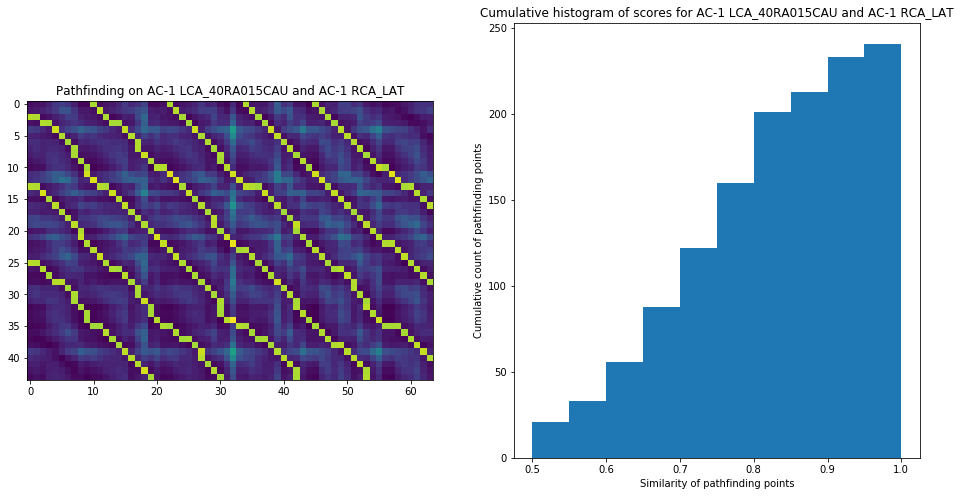

distance_matrix (47, 47)
ground_truth (47, 47)


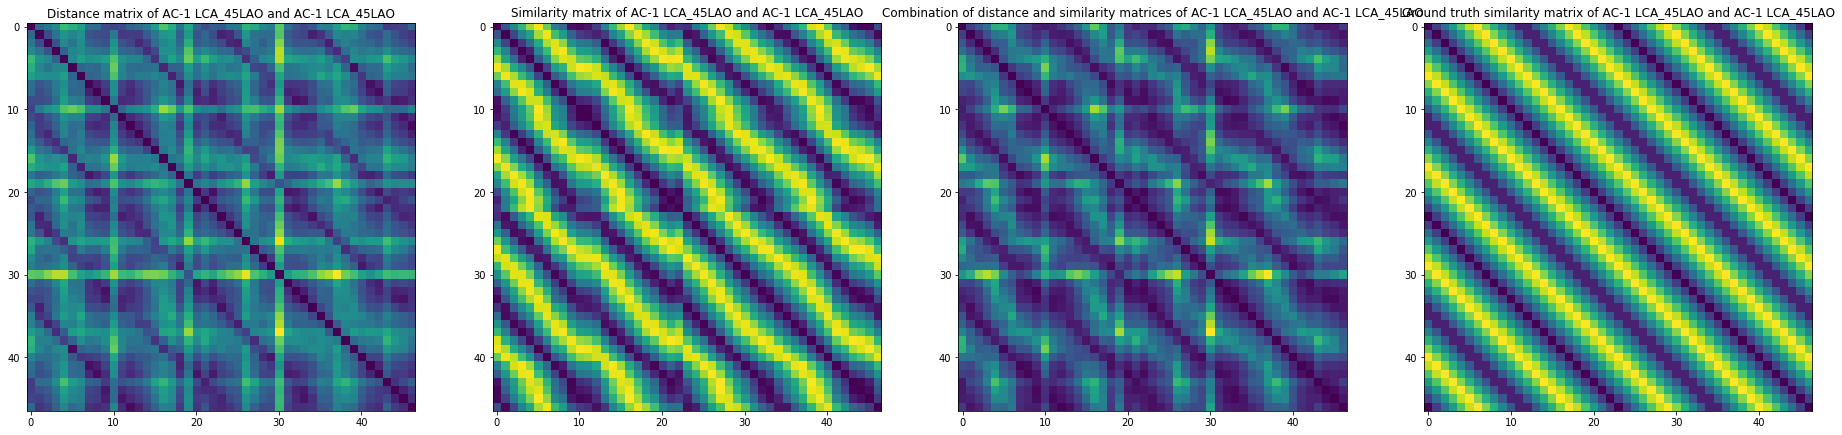

Mean score: 0.9009356081452947 for 158 scores


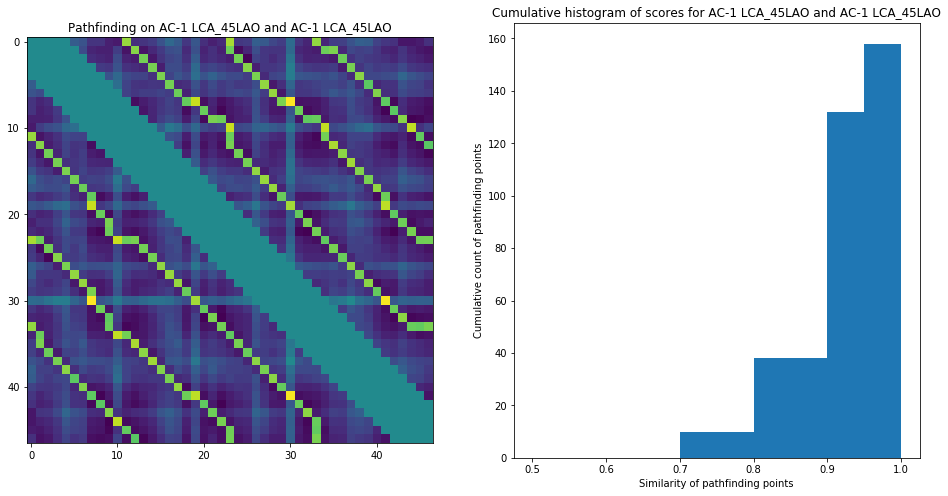

Mean score: 0.9119699409554483 for 162 scores


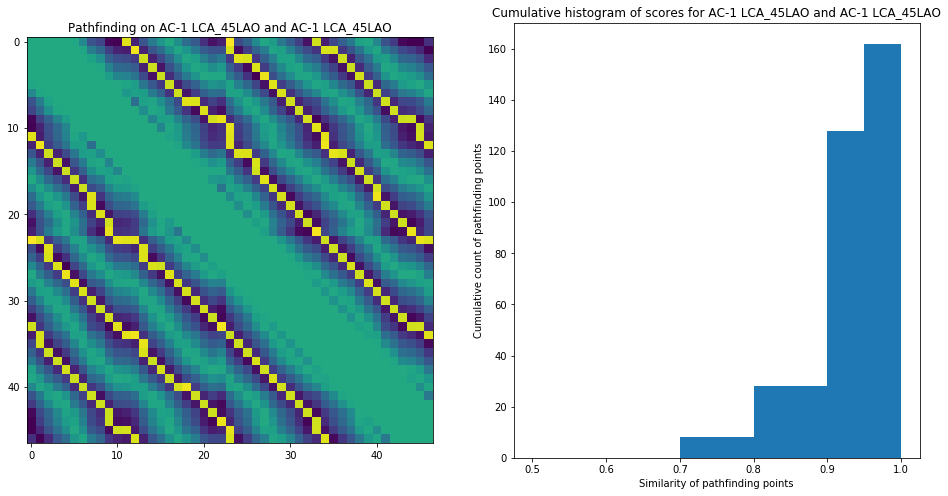

Mean score: 0.9054347826086957 for 160 scores


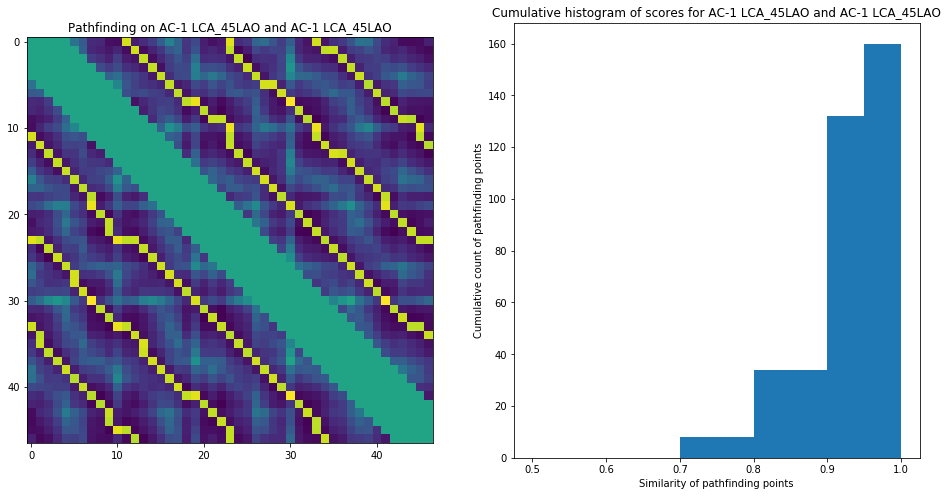

distance_matrix (47, 51)
ground_truth (47, 51)


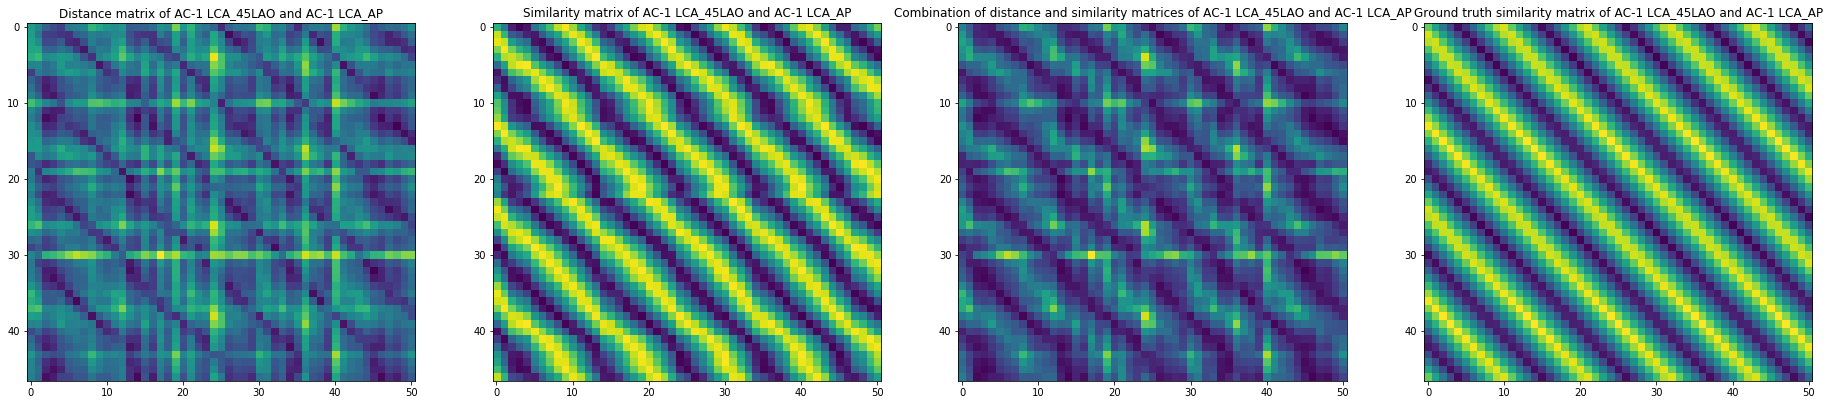

Mean score: 0.8850956661653083 for 226 scores


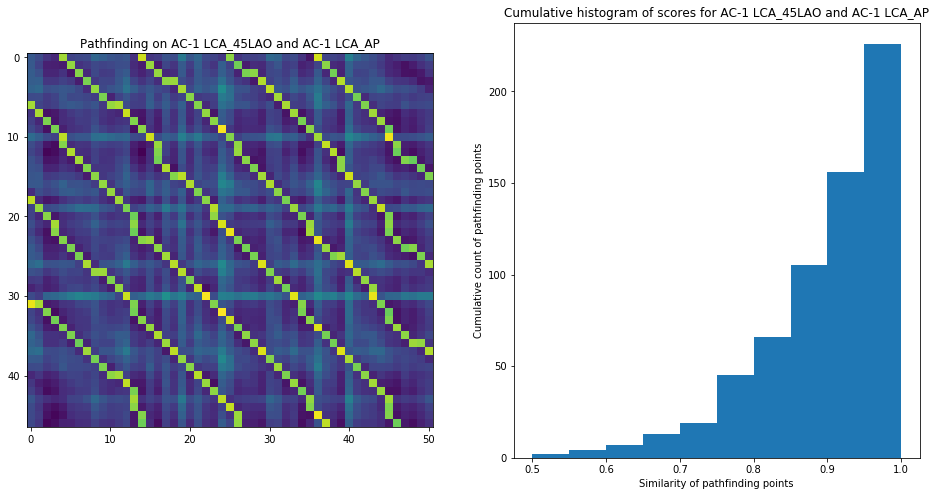

Mean score: 0.8816624745478499 for 231 scores


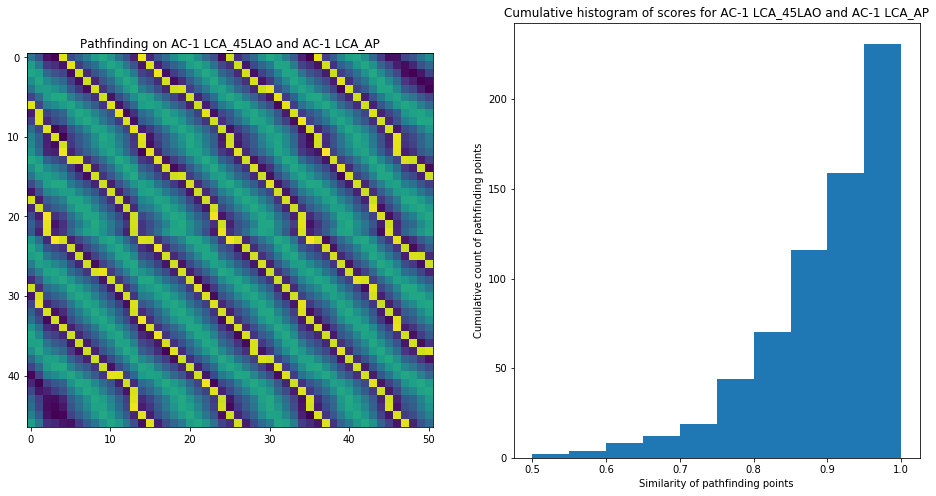

Mean score: 0.8774529435322387 for 227 scores


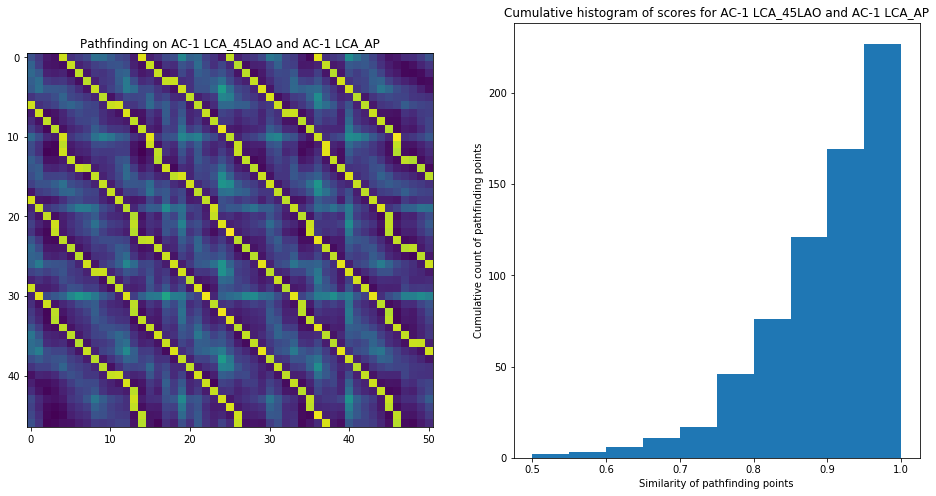

distance_matrix (47, 49)
ground_truth (47, 49)


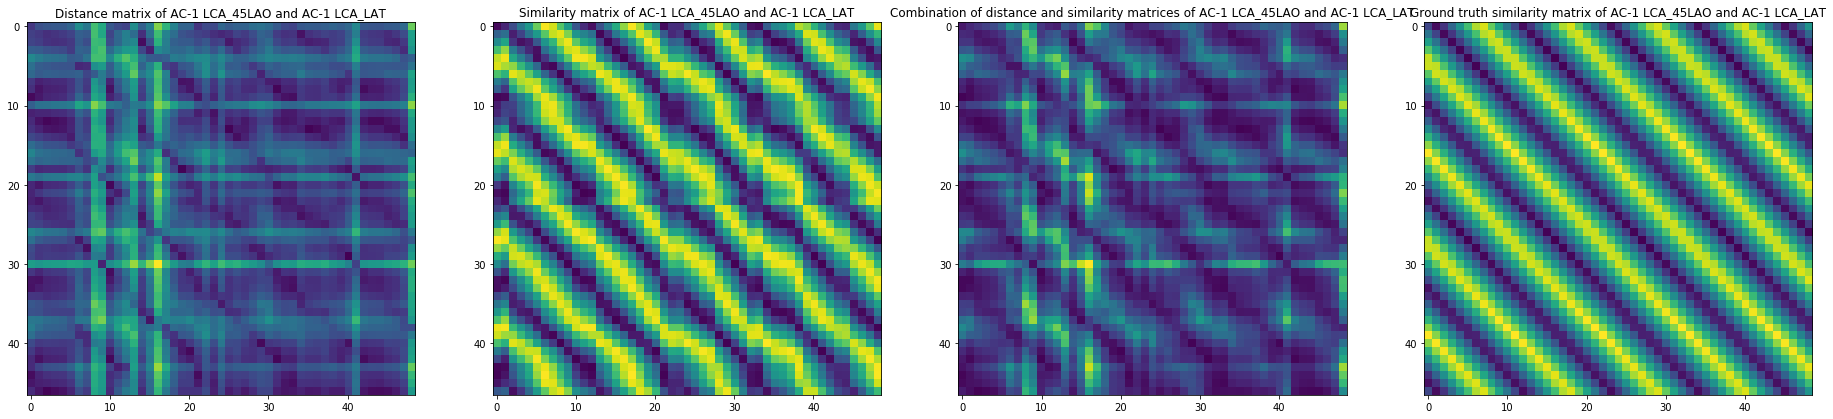

Mean score: 0.8778888630551033 for 170 scores


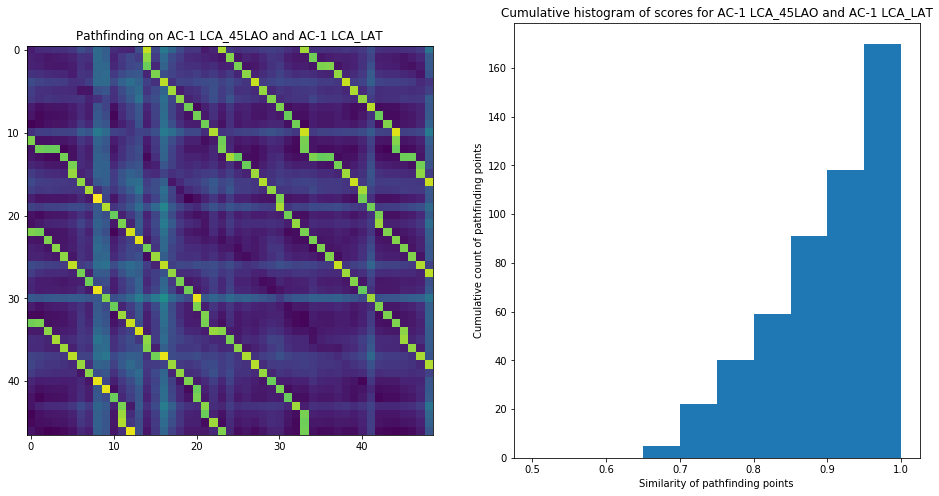

Mean score: 0.8831953774437687 for 223 scores


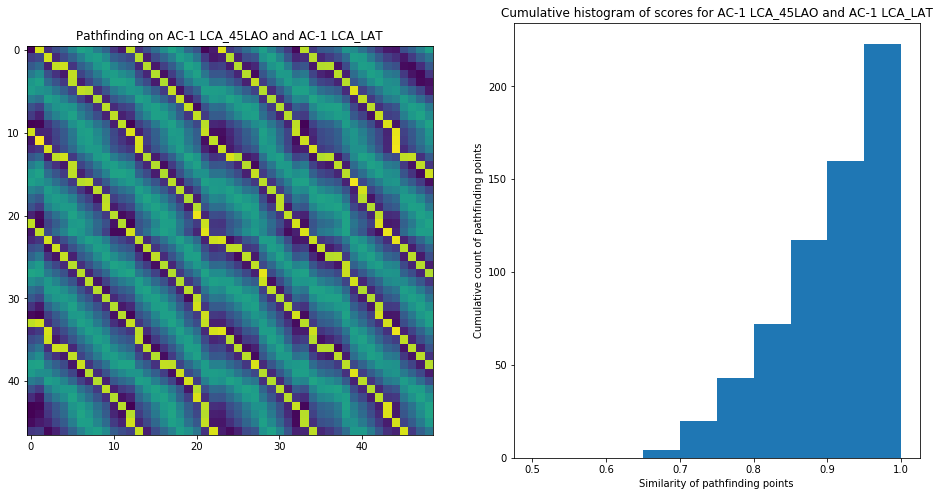

Mean score: 0.8811747815452241 for 223 scores


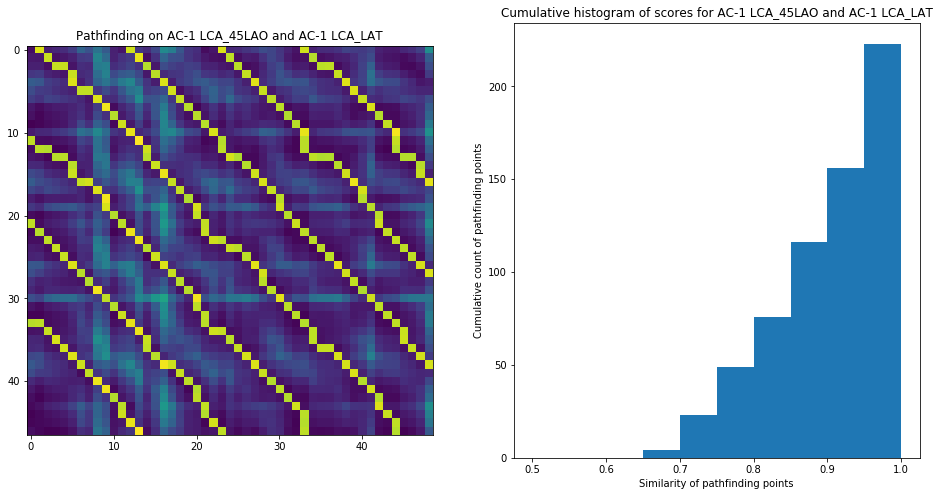

distance_matrix (47, 67)
ground_truth (47, 67)


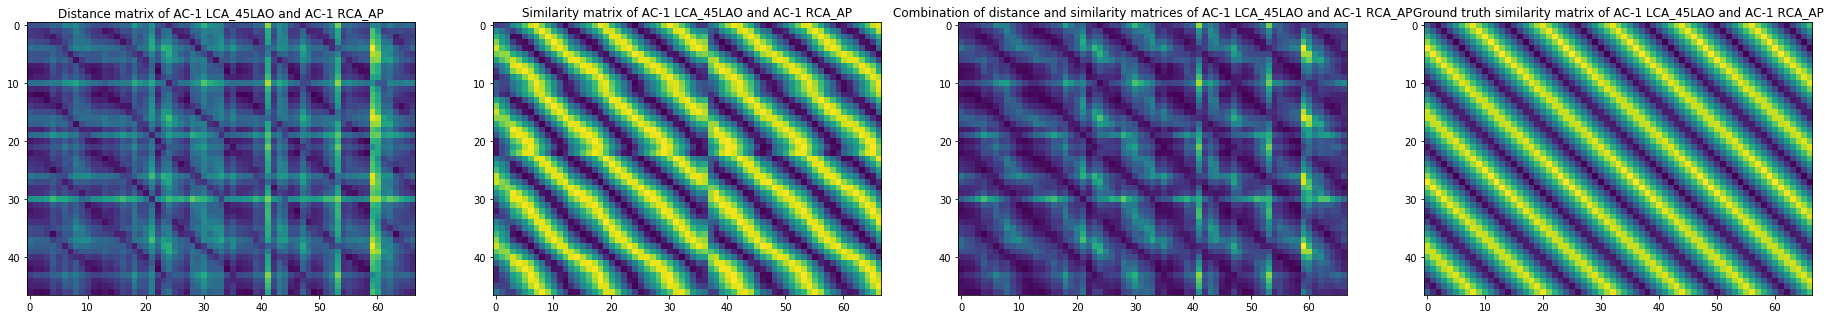

Mean score: 0.8800207039337473 for 280 scores


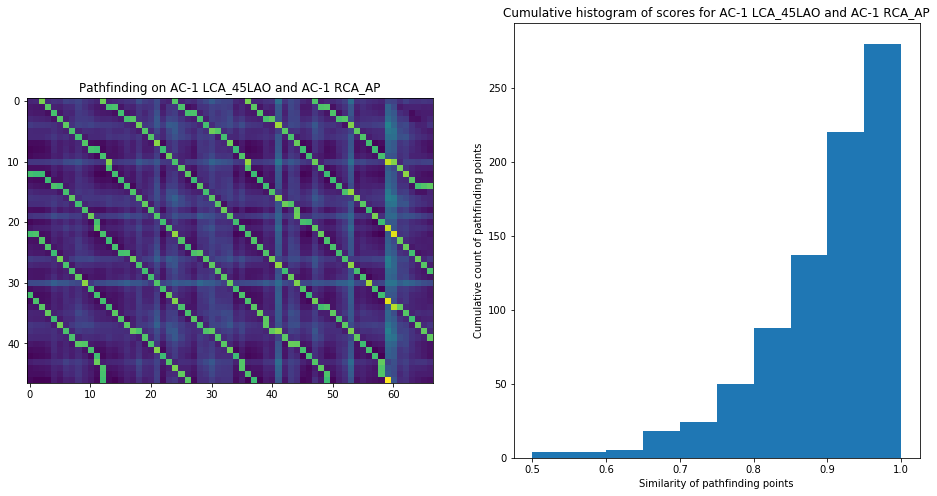

Mean score: 0.8747555288099894 for 289 scores


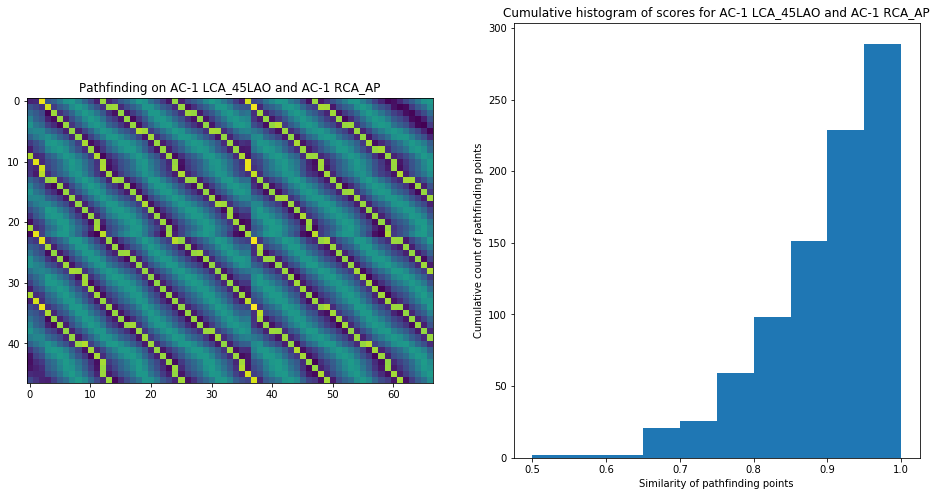

Mean score: 0.8767345050878815 for 282 scores


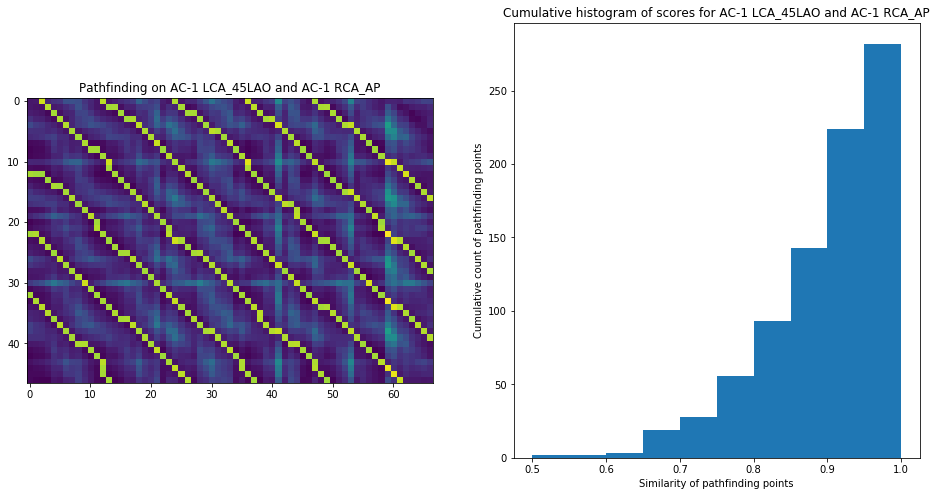

distance_matrix (47, 64)
ground_truth (47, 64)


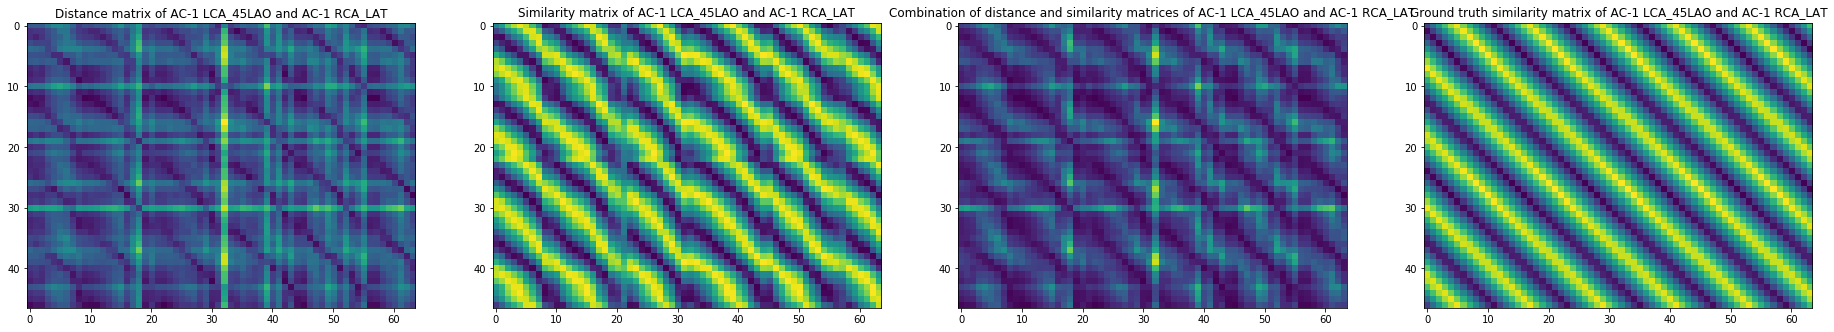

Mean score: 0.8174069440100095 for 278 scores


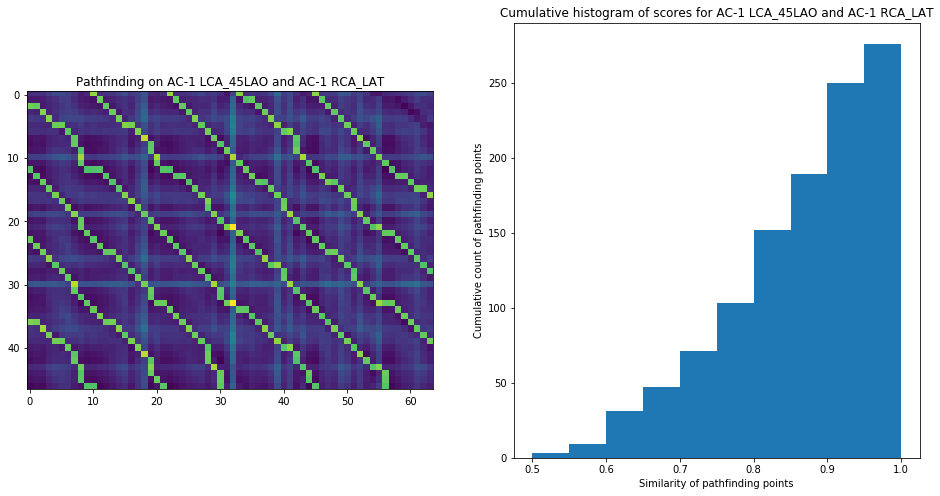

Mean score: 0.8125928201976749 for 283 scores


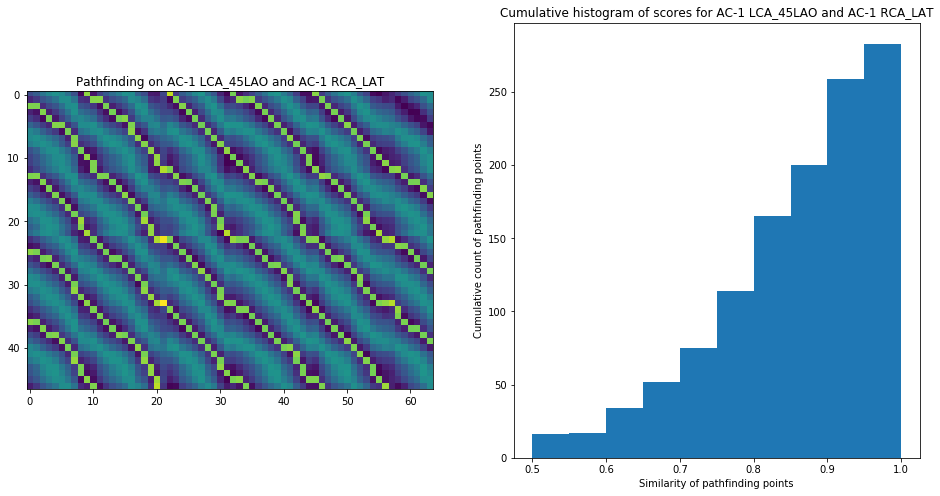

Mean score: 0.8226861298592582 for 277 scores


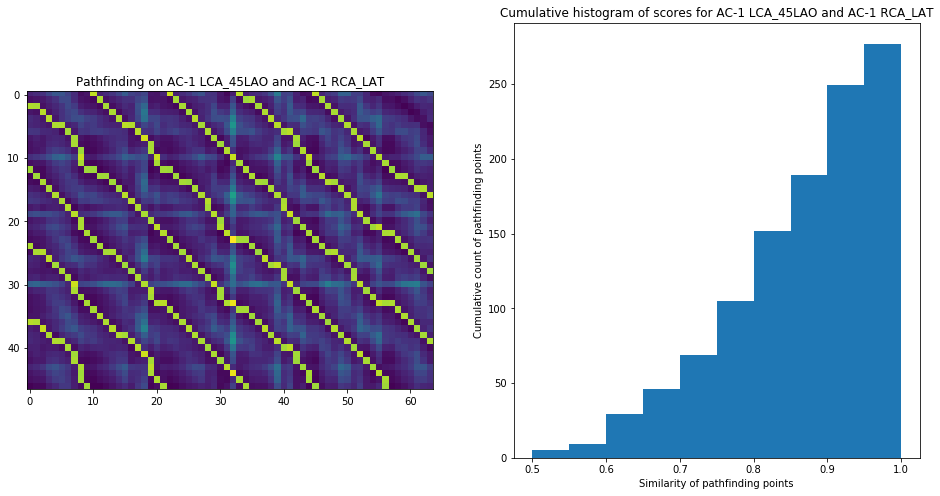

distance_matrix (51, 51)
ground_truth (51, 51)


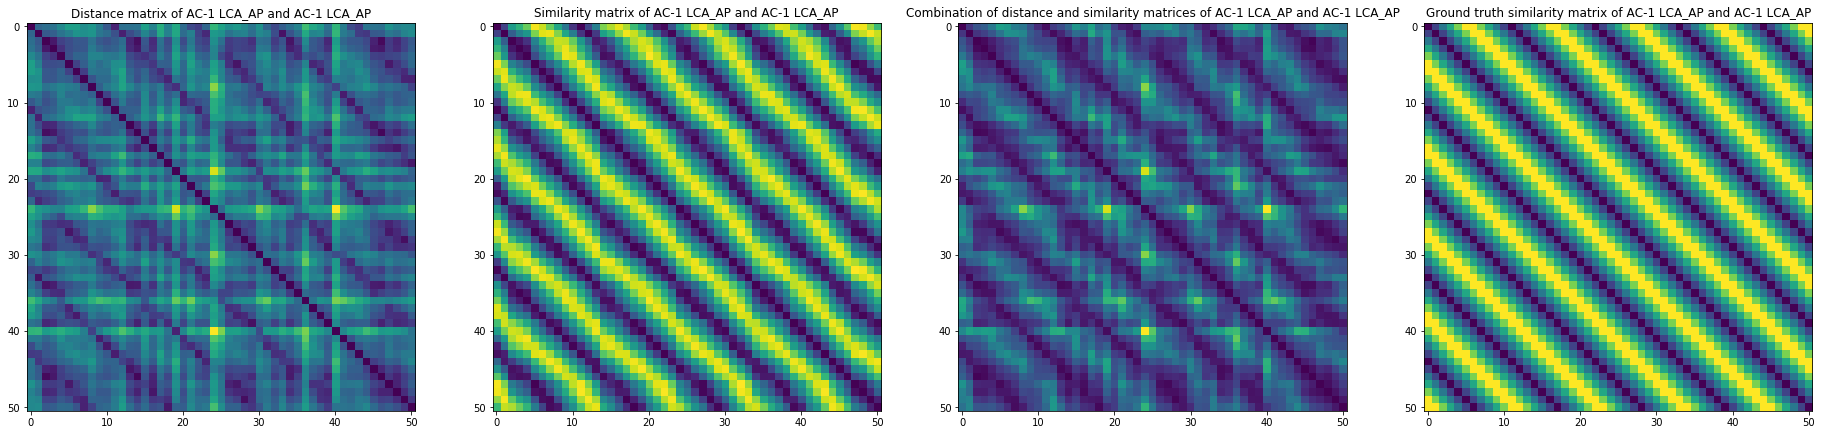

Mean score: 0.8878143133462282 for 188 scores


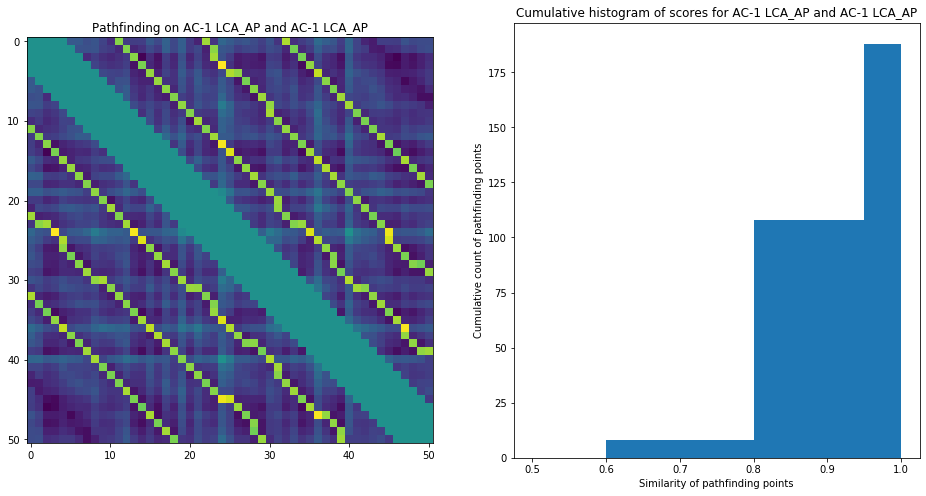

Mean score: 0.8873517786561267 for 184 scores


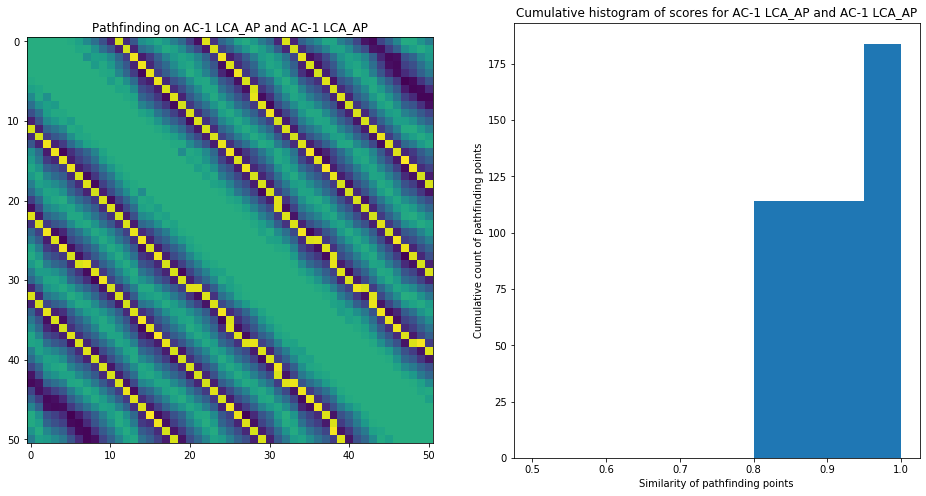

Mean score: 0.8924731182795699 for 186 scores


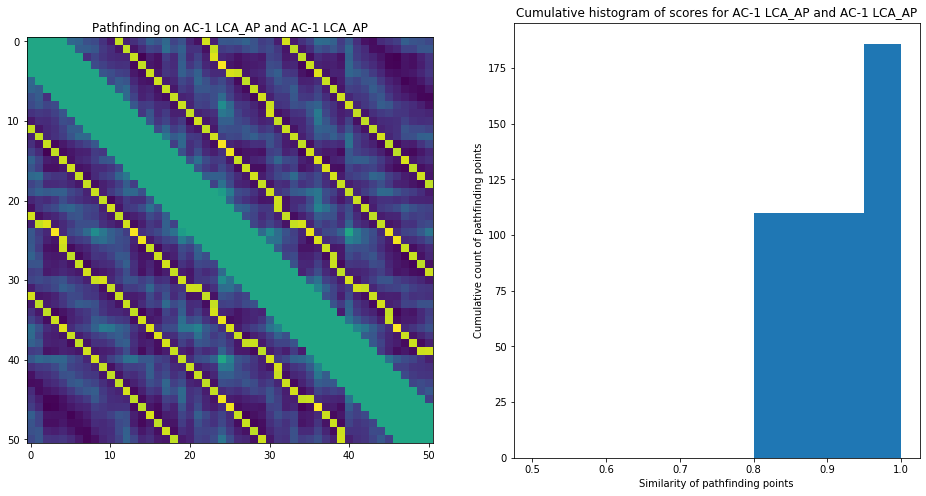

distance_matrix (51, 49)
ground_truth (51, 49)


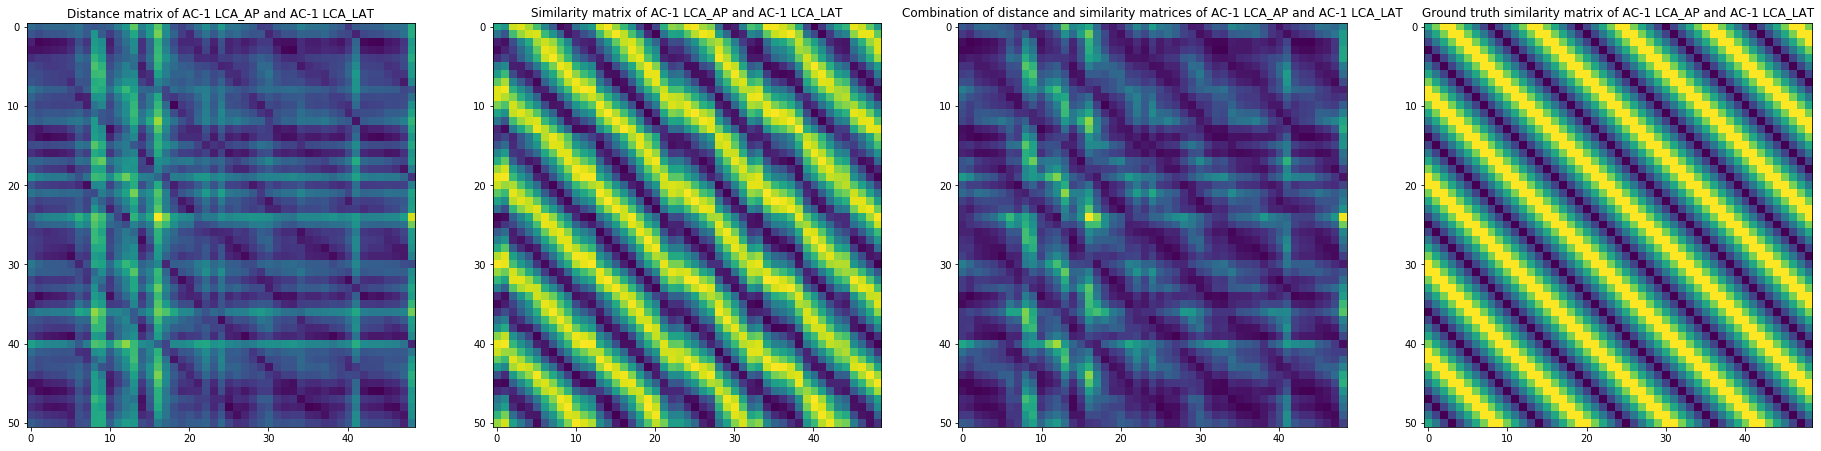

Mean score: 0.8730277986476334 for 242 scores


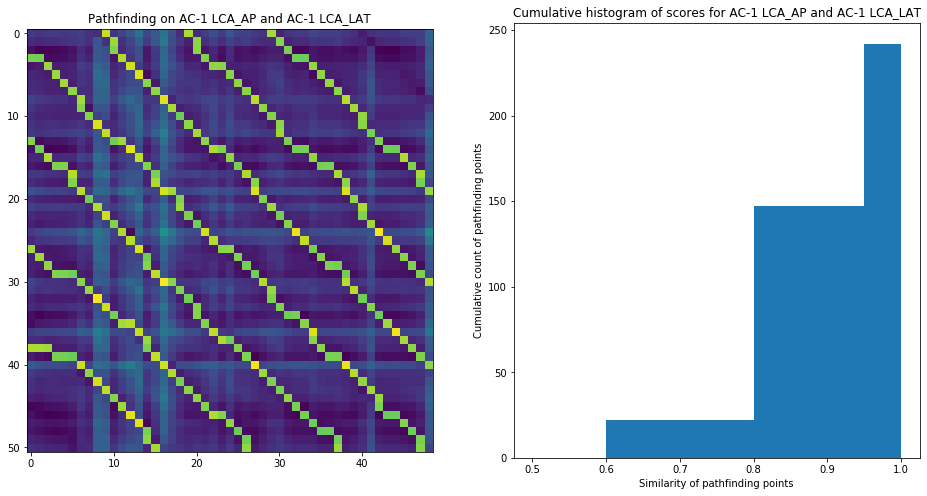

Mean score: 0.8569299552906111 for 244 scores


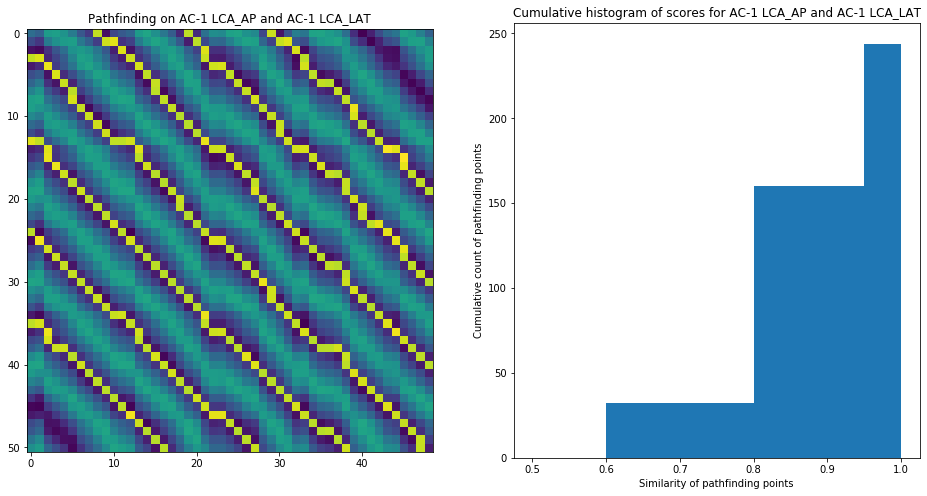

Mean score: 0.8694083694083695 for 252 scores


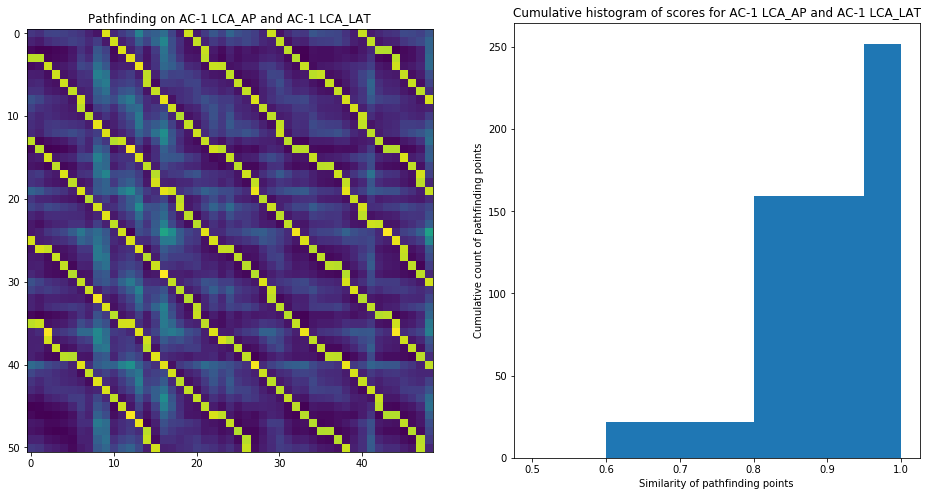

distance_matrix (51, 67)
ground_truth (51, 67)


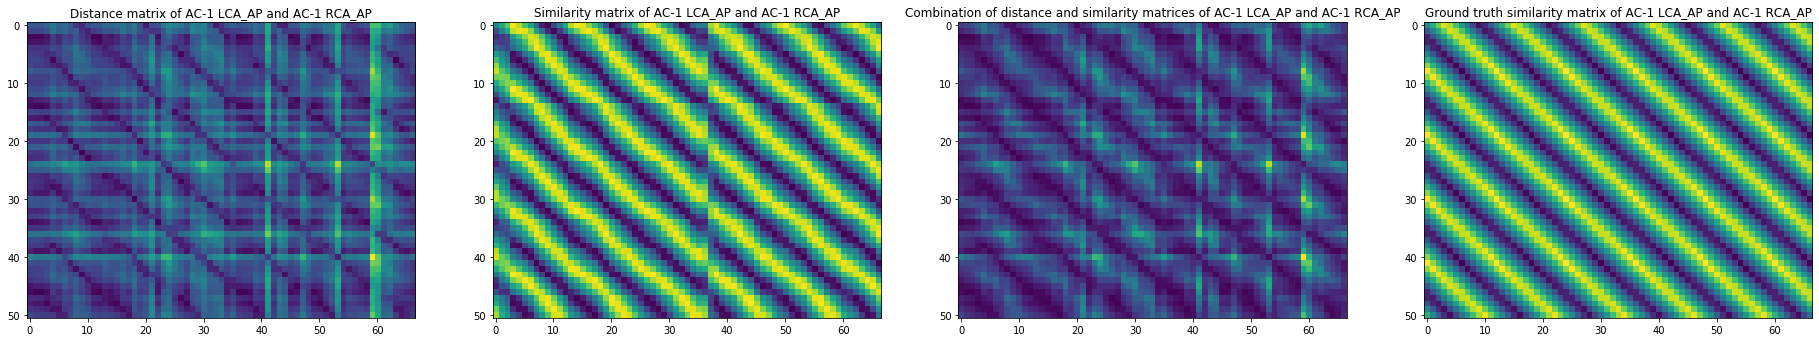

Mean score: 0.8648325358851674 for 266 scores


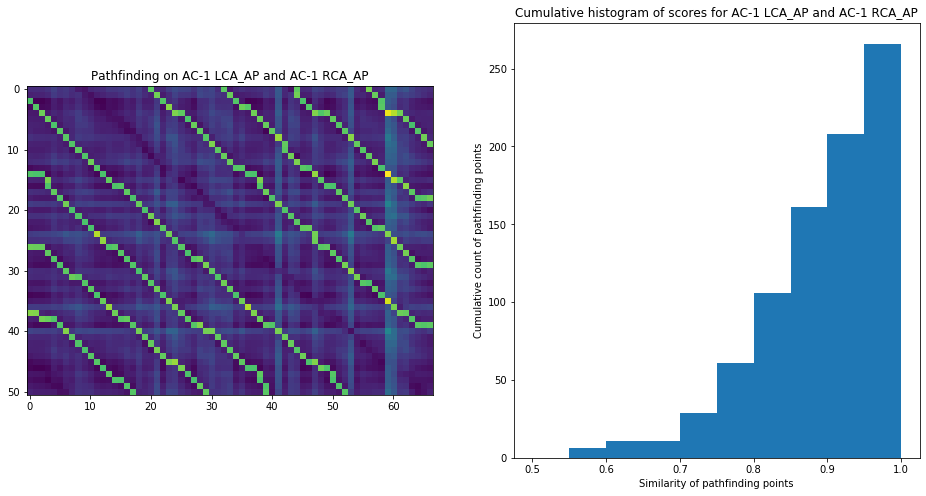

Mean score: 0.8877367424242424 for 320 scores


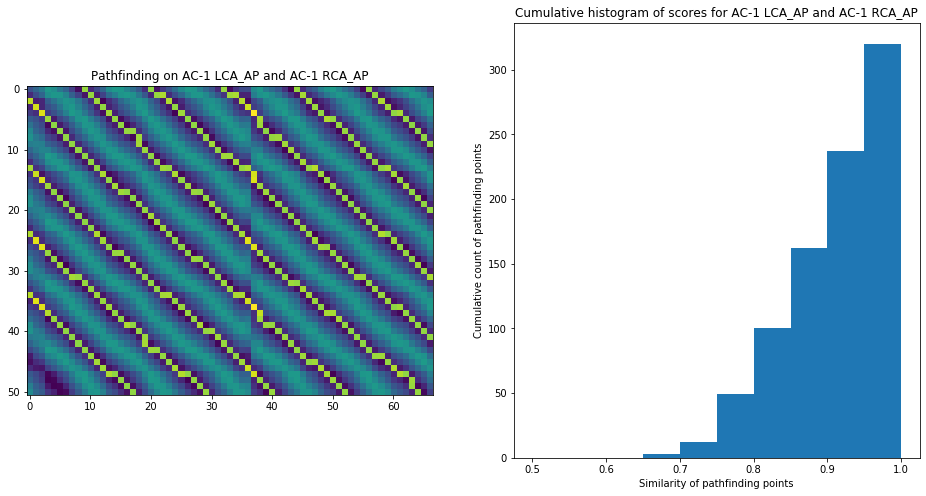

Mean score: 0.875058275058275 for 325 scores


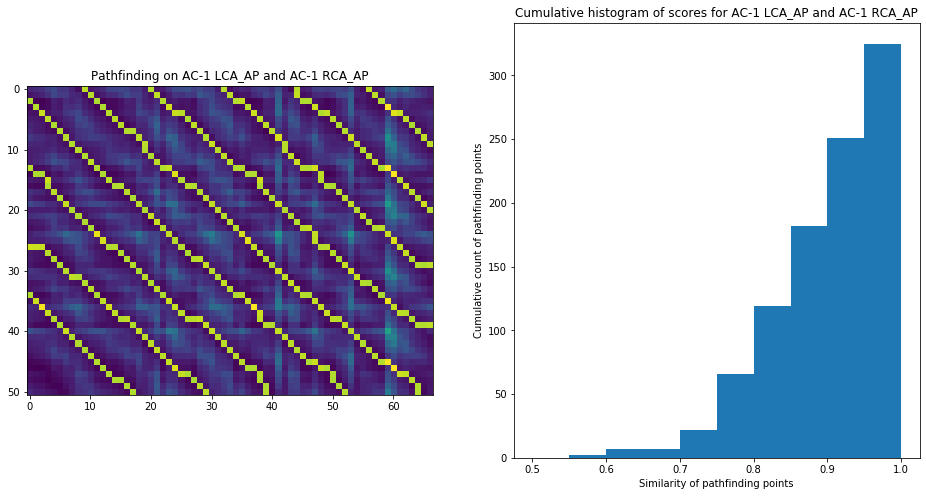

distance_matrix (51, 64)
ground_truth (51, 64)


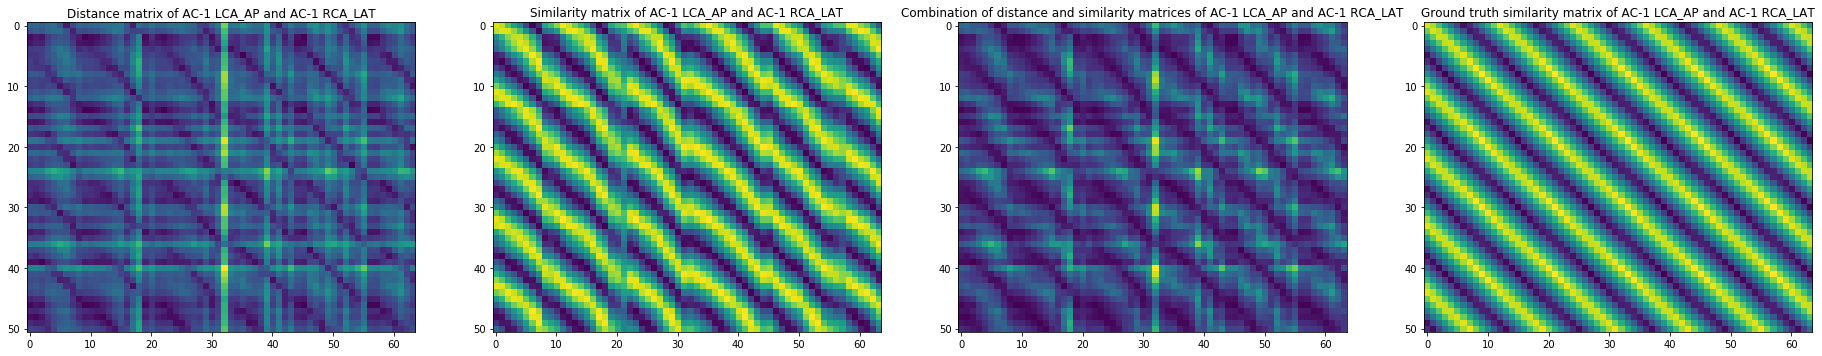

Mean score: 0.8291454921889705 for 322 scores


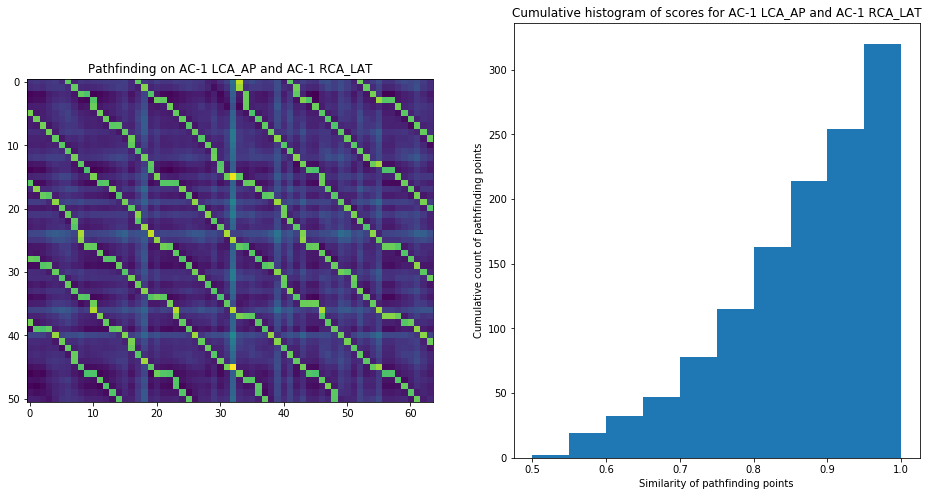

Mean score: 0.8334753787878787 for 320 scores


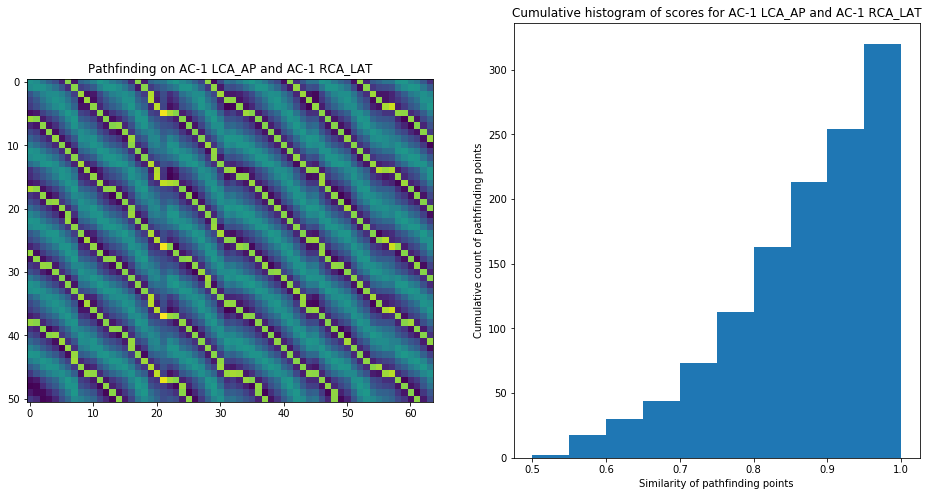

Mean score: 0.8331903945111492 for 318 scores


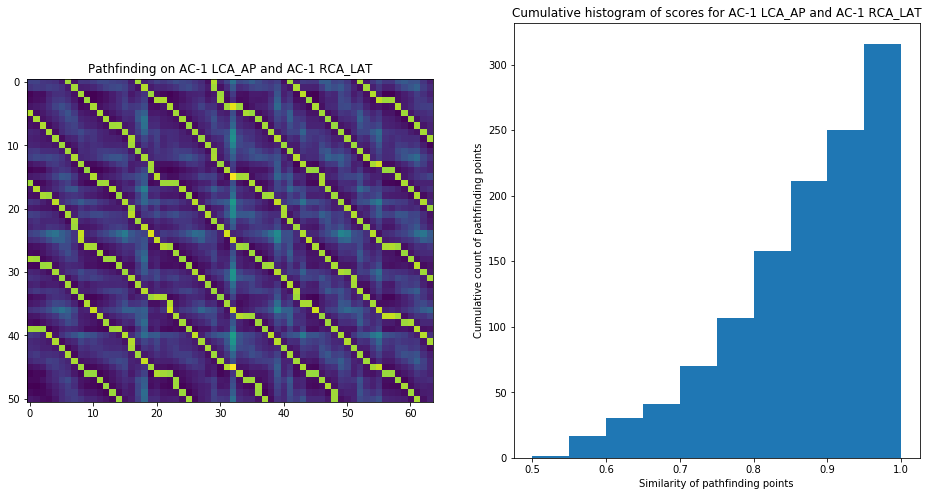

distance_matrix (49, 49)
ground_truth (49, 49)


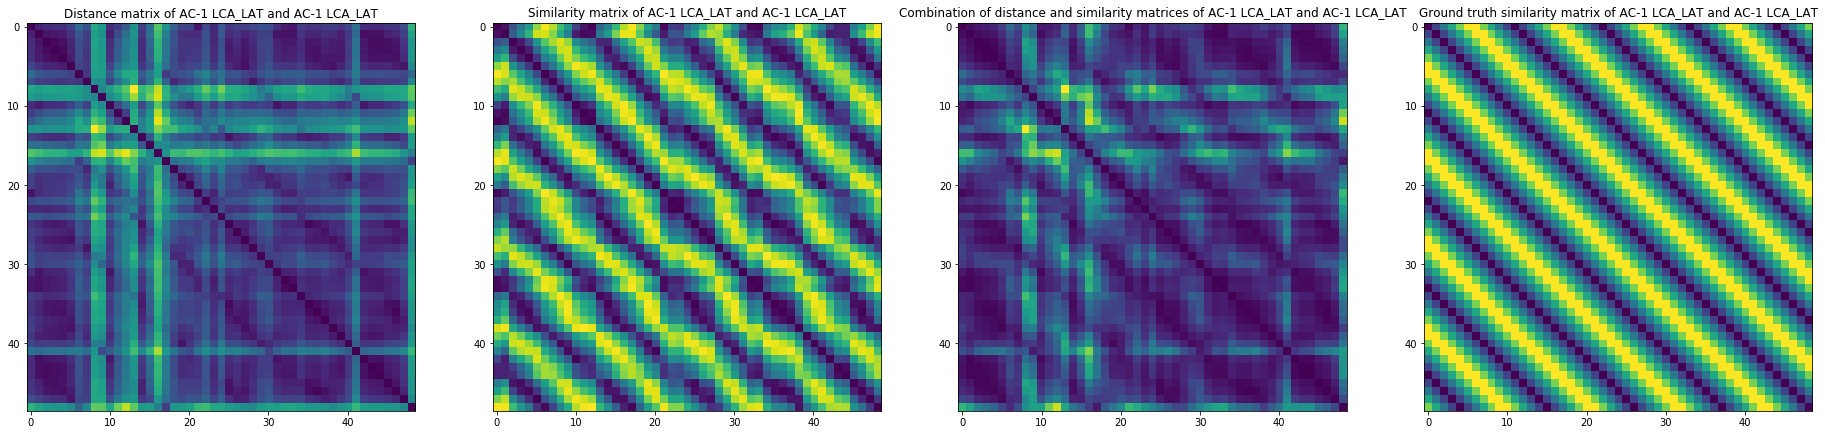

c:\logiciels\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: Mean of empty slice.


Mean score: nan for 0 scores


c:\logiciels\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: Mean of empty slice.


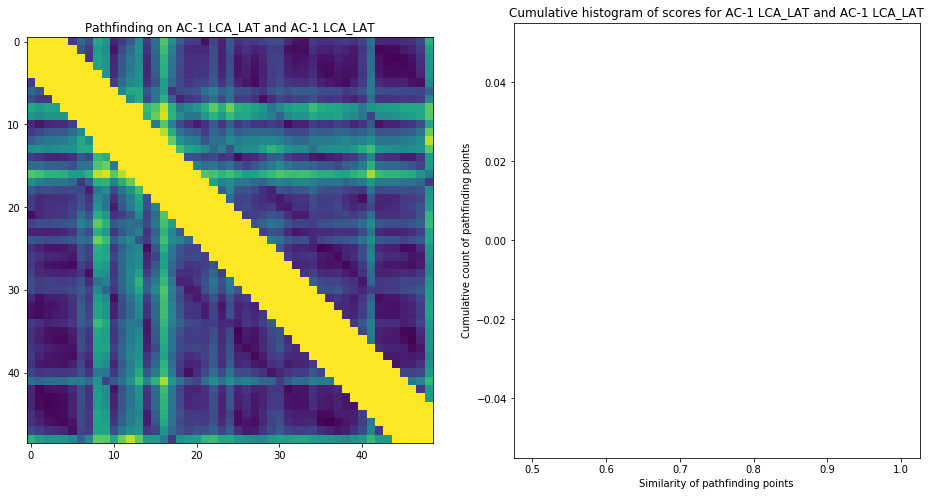

Mean score: 0.8826979472140762 for 186 scores


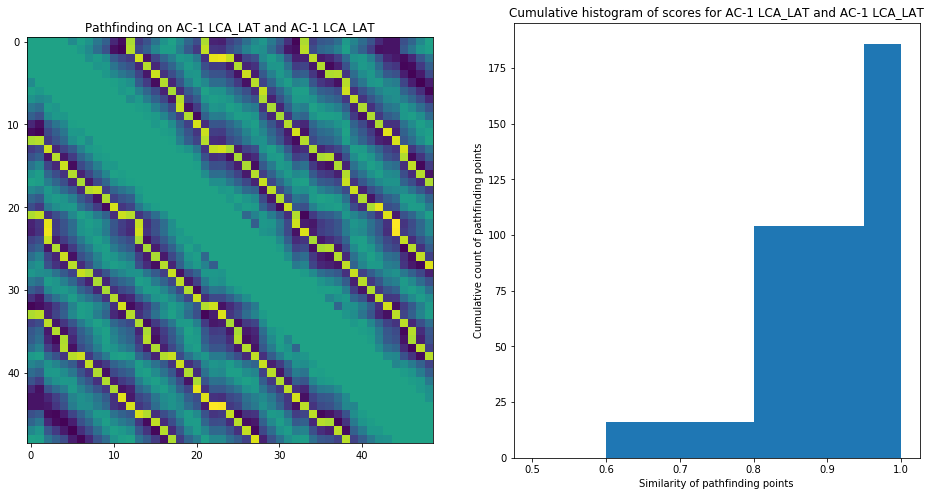

Mean score: 0.890909090909091 for 180 scores


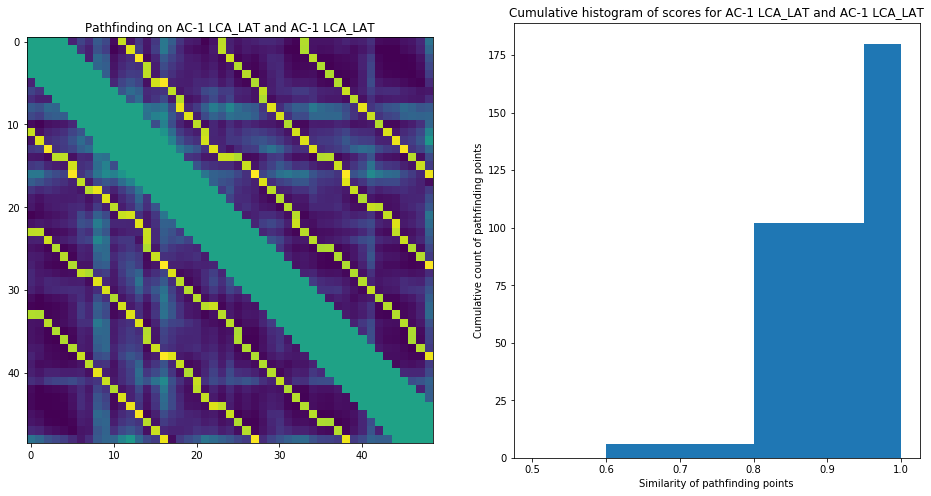

distance_matrix (49, 67)
ground_truth (49, 67)


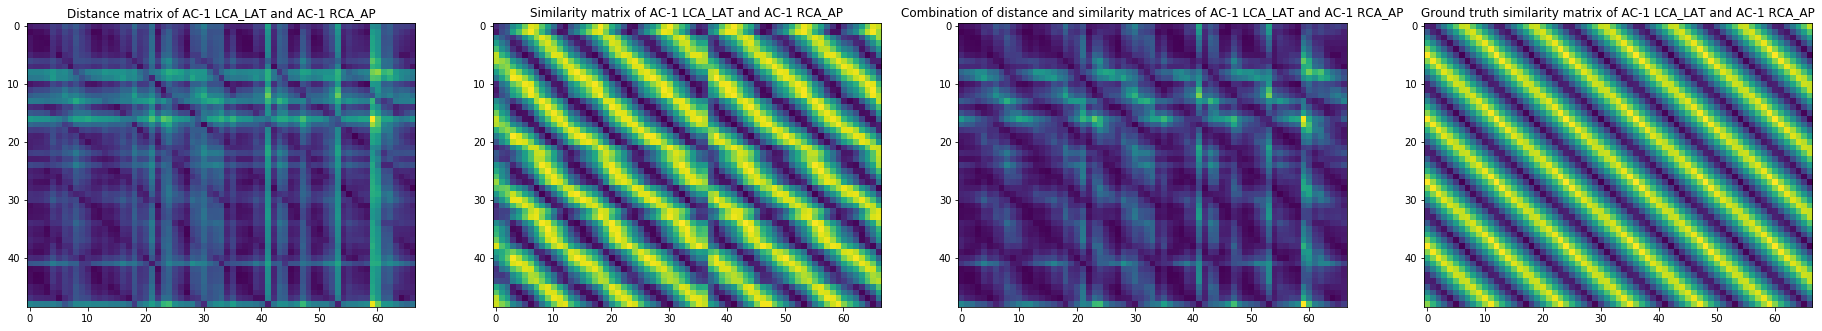

Mean score: 0.7743817485196794 for 174 scores


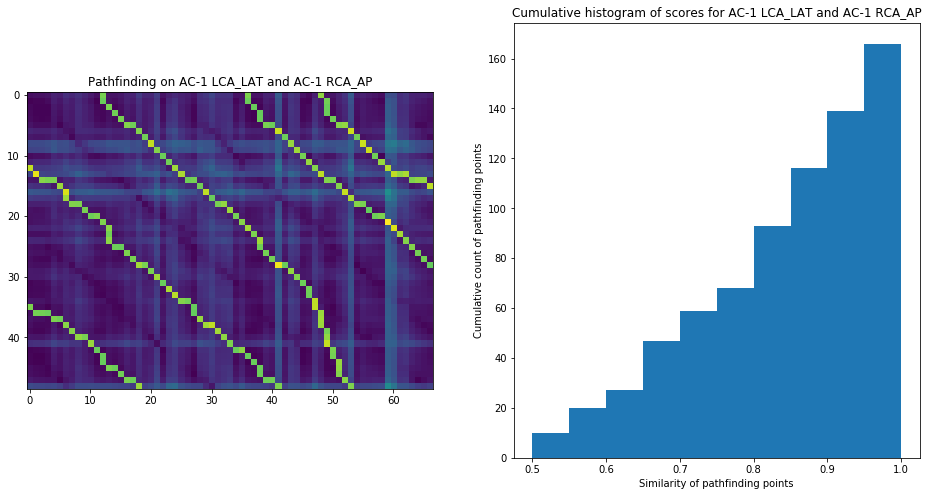

Mean score: 0.8275499474237644 for 317 scores


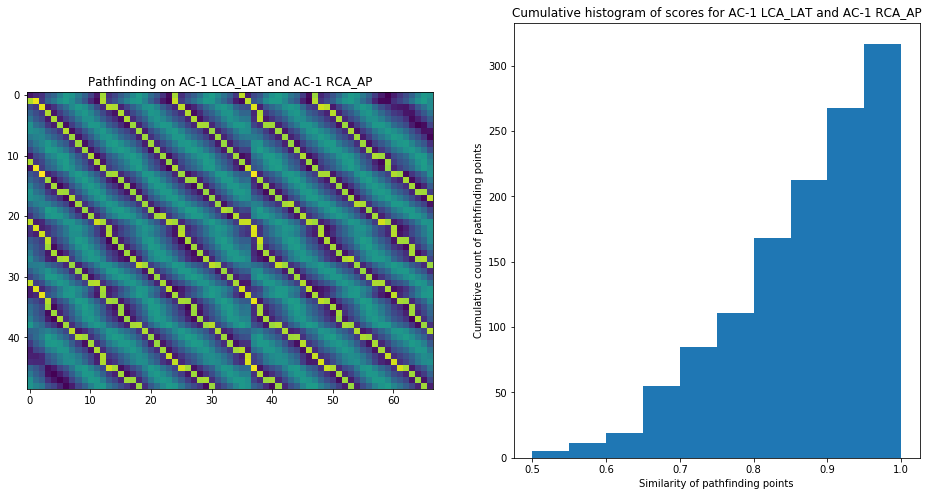

Mean score: 0.825326045262754 for 316 scores


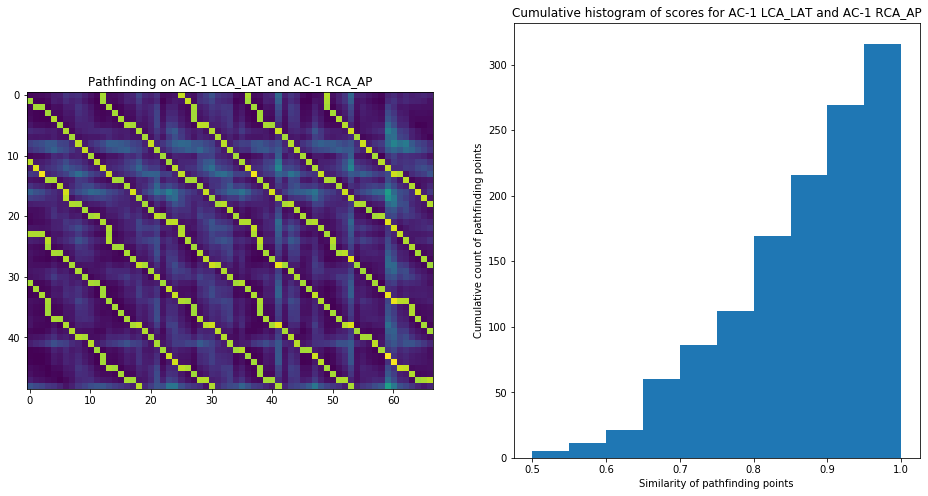

distance_matrix (49, 64)
ground_truth (49, 64)


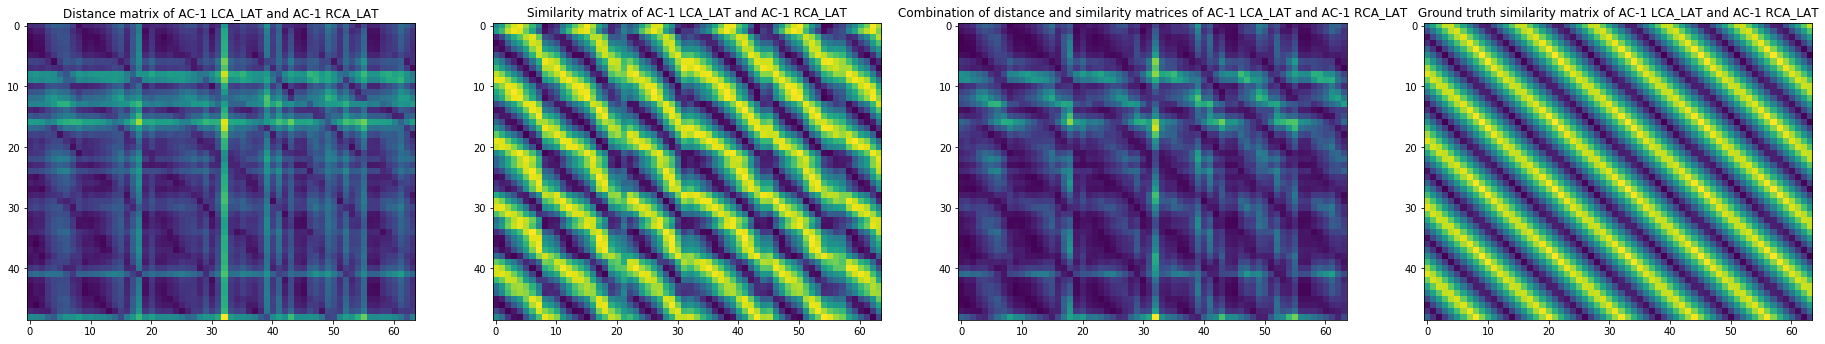

Mean score: 0.7784709843533373 for 153 scores


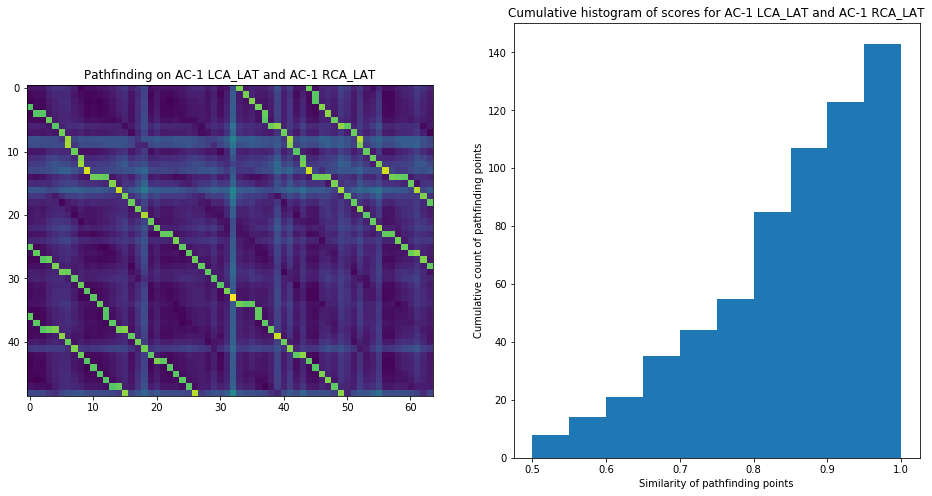

Mean score: 0.7816487240829346 for 304 scores


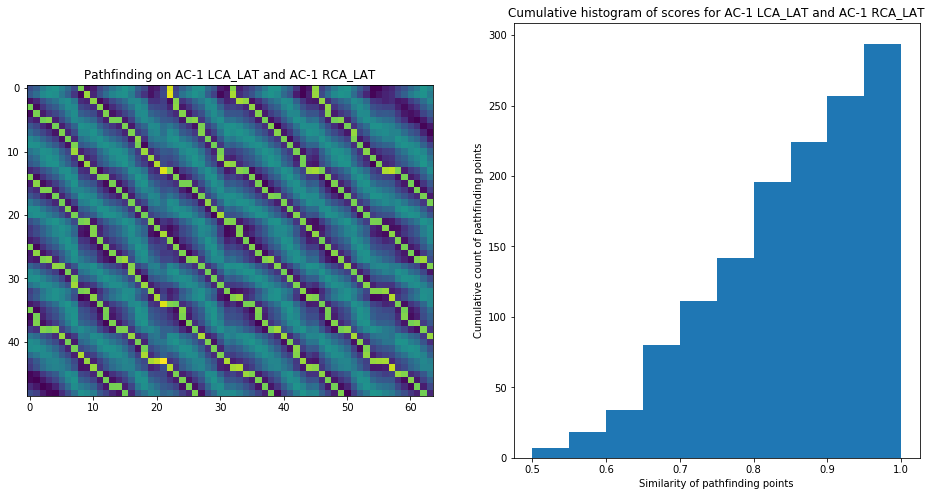

Mean score: 0.793675005084401 for 298 scores


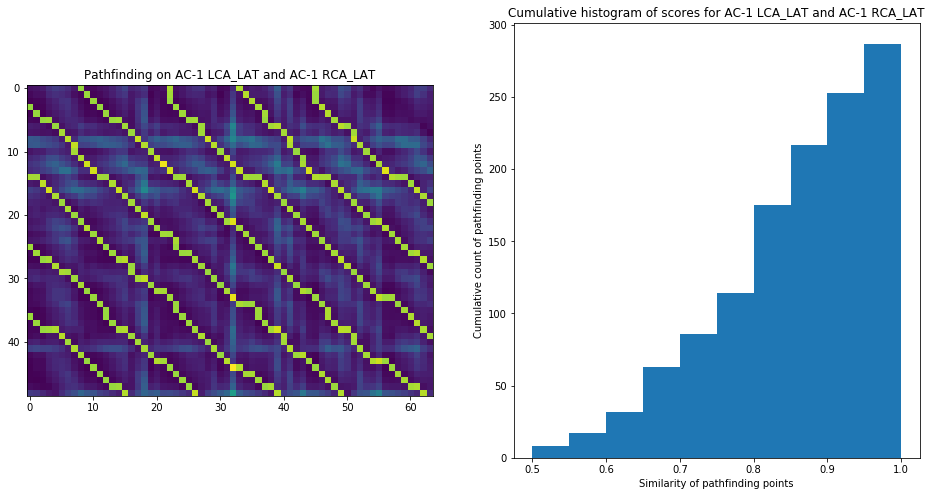

distance_matrix (67, 67)
ground_truth (67, 67)


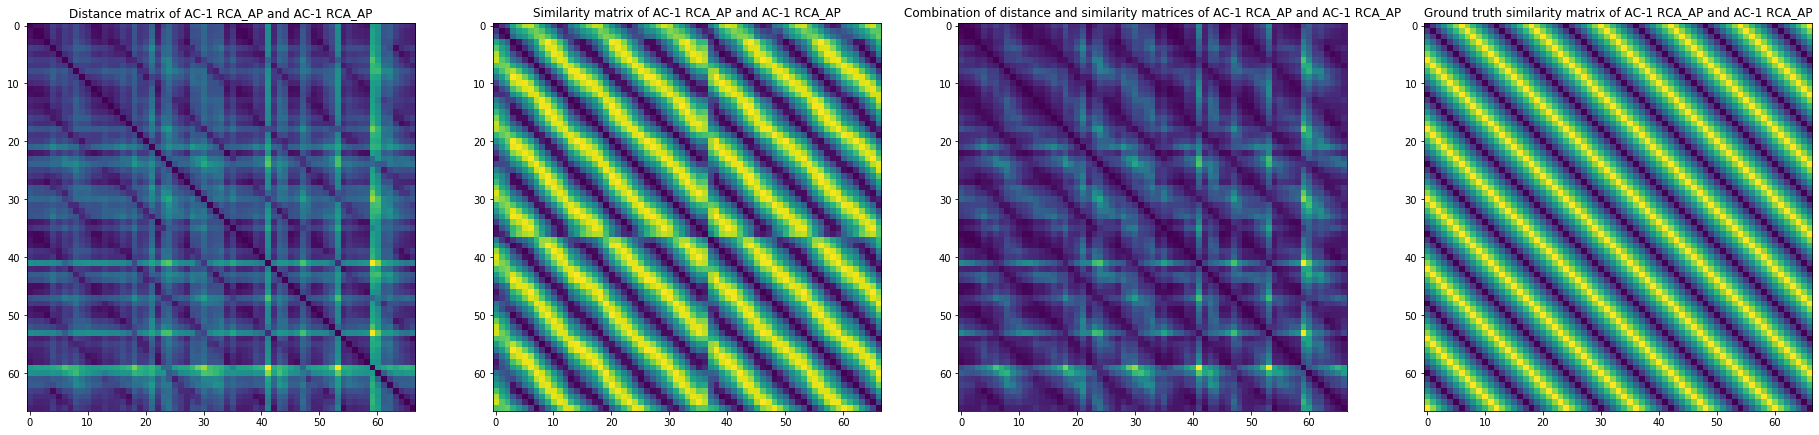

Mean score: 0.8913978494623656 for 310 scores


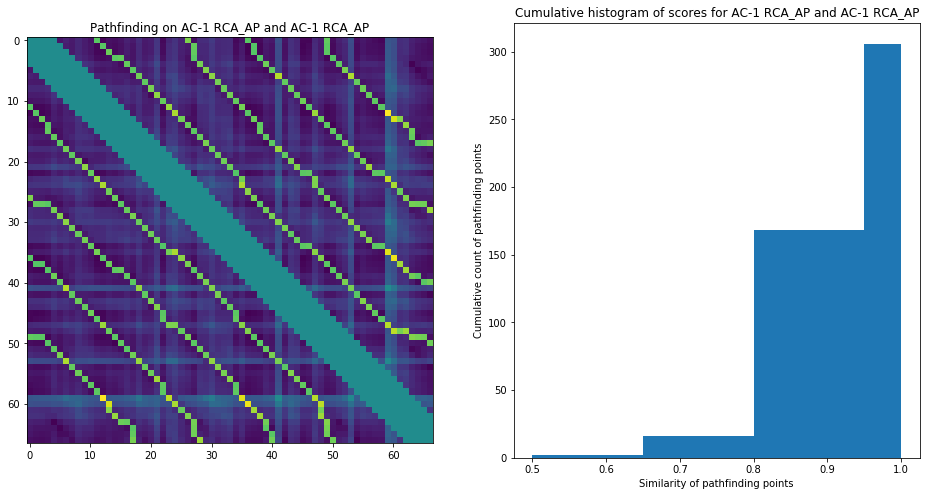

Mean score: 0.9006211180124224 for 322 scores


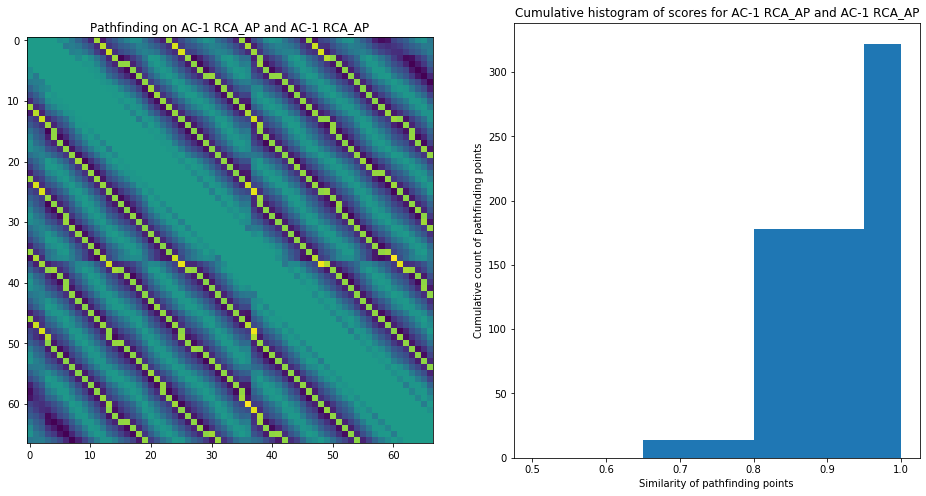

Mean score: 0.910828025477707 for 314 scores


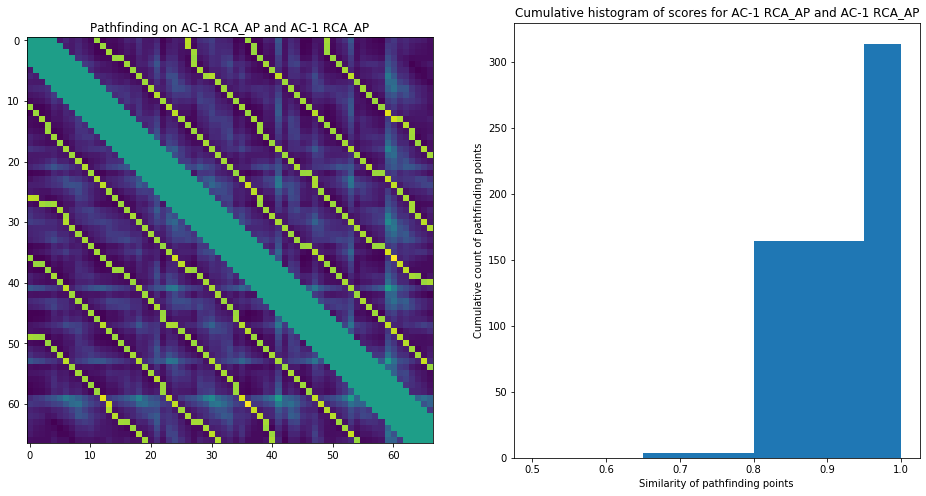

distance_matrix (67, 64)
ground_truth (67, 64)


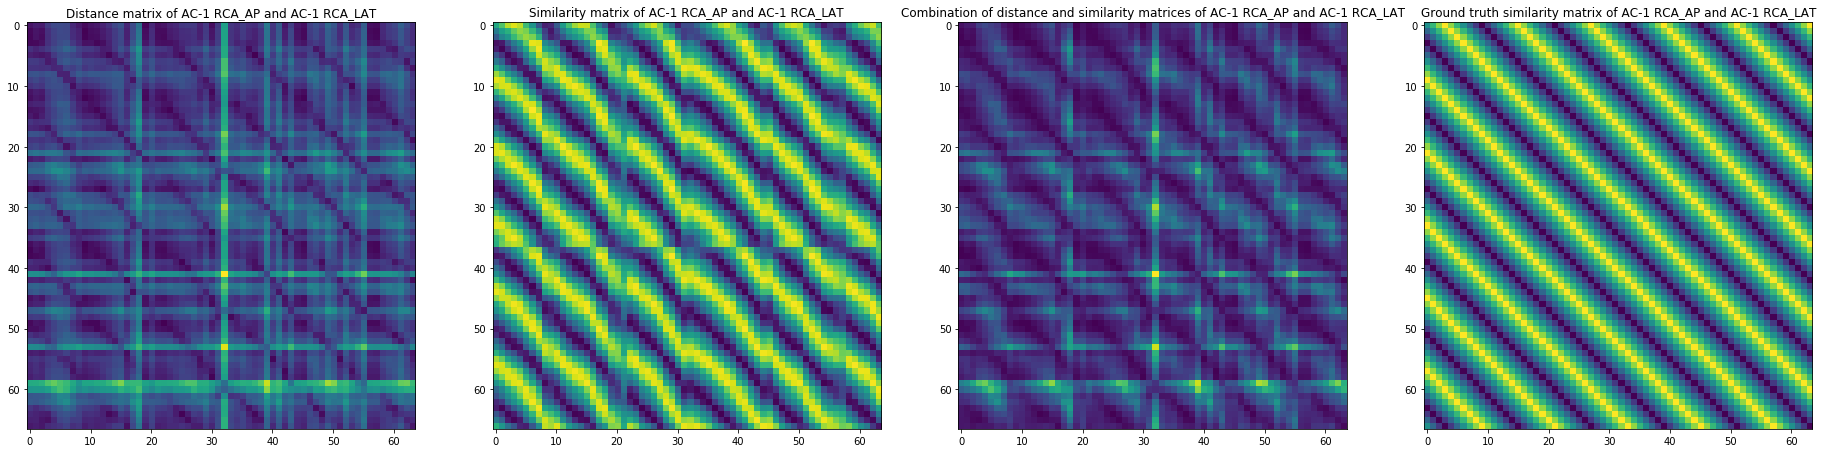

Mean score: 0.8597046413502109 for 316 scores


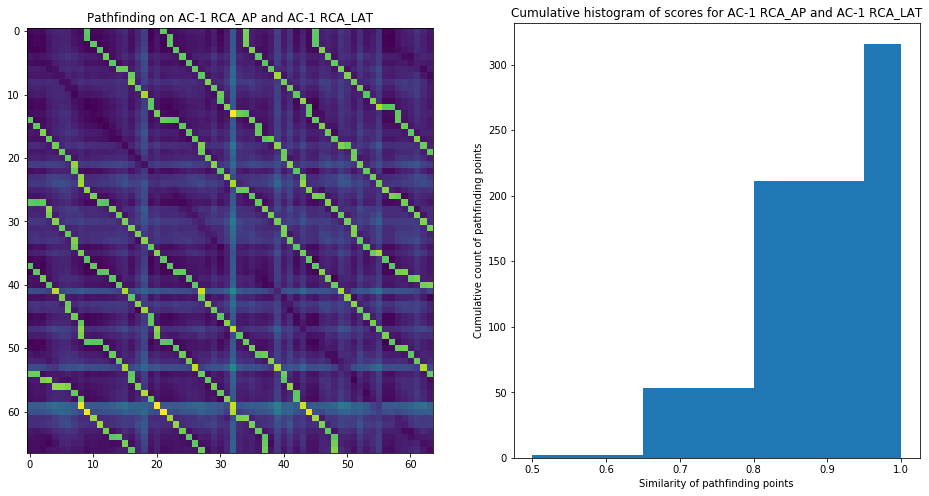

Mean score: 0.8799145299145298 for 390 scores


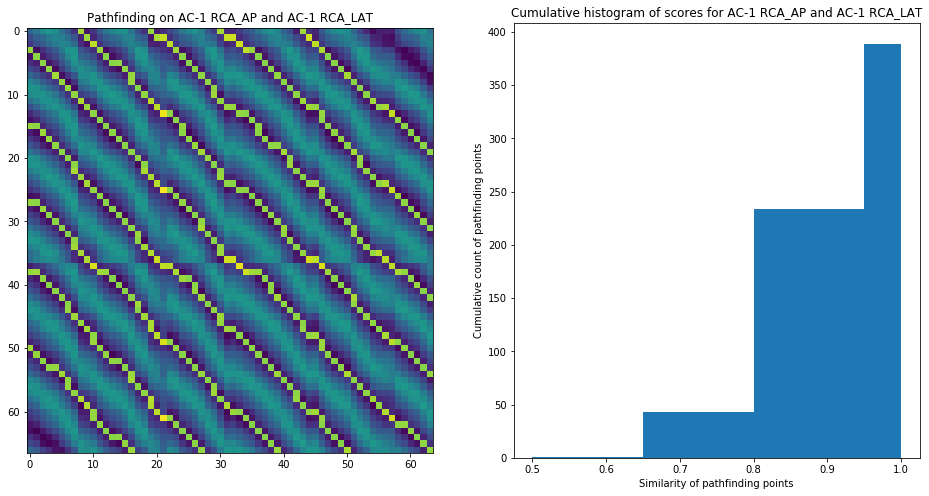

Mean score: 0.8770351328191944 for 389 scores


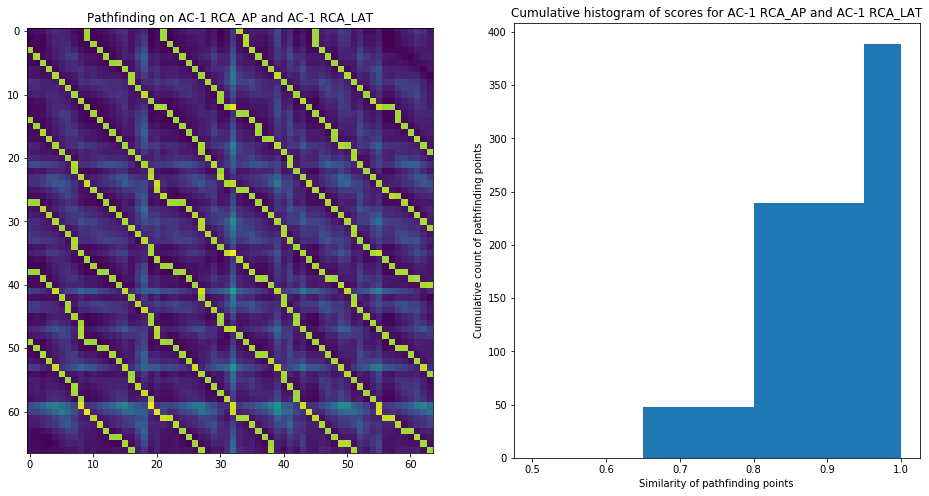

distance_matrix (64, 64)
ground_truth (64, 64)


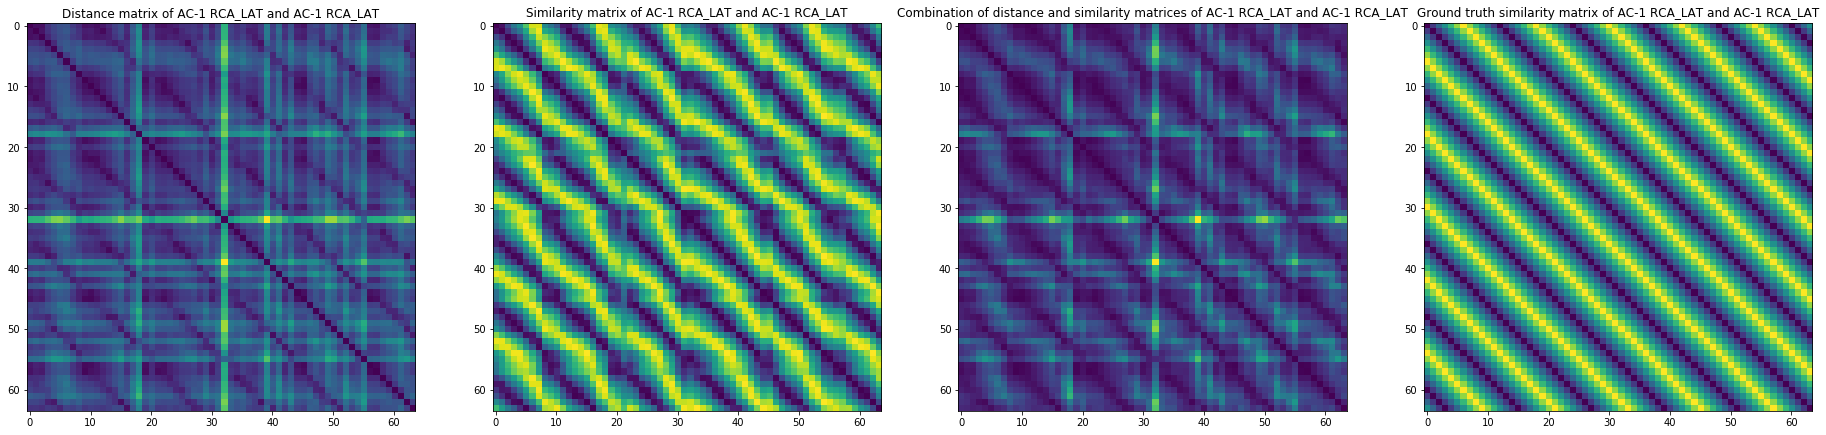

Mean score: 0.8741496598639455 for 294 scores


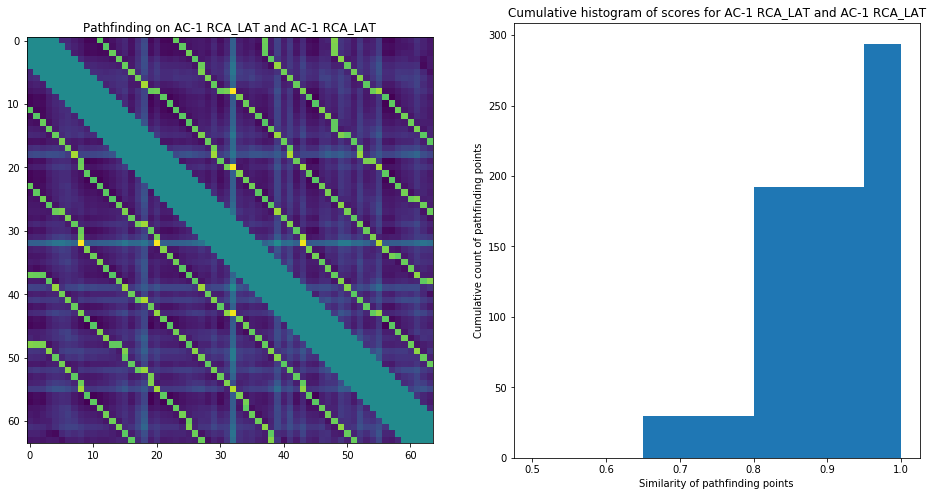

Mean score: 0.8830022075055186 for 302 scores


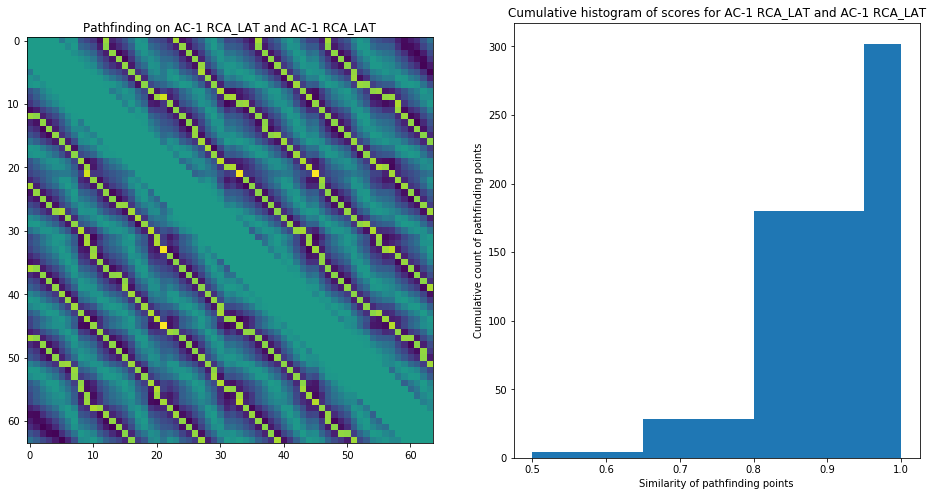

Mean score: 0.8809523809523809 for 294 scores


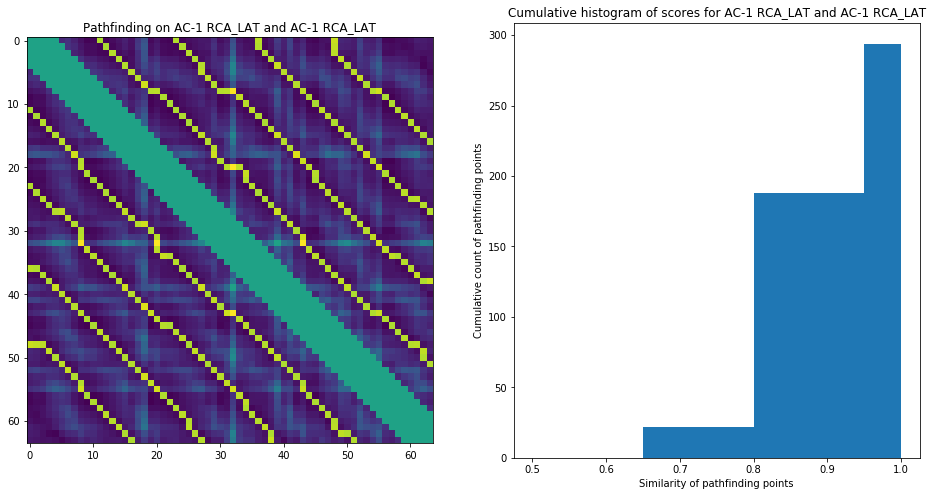

In [16]:
import utils
reload(utils)
from utils import pathfinding

save_pairs = False
good_angle_pairs = [
    # ("G1 18", "G1 20")
#     ("G18 10", "G18 18"),
#     ("G18 13", "G18 17"),
#     ("G18 13", "G18 18"),
#     ("G18 14", "G18 18"),
#     ("G18 15", "G18 18"),
#     ("G18 17", "G18 18"),
#     ("G18 18", "G18 18"),
#     ("G18 18", "G18 19"),
#     ("G18 18", "G18 9")
]

all_distance_scores = np.array([])
all_similarity_scores = np.array([])
all_combination_scores = np.array([])
ordered_distance_scores = []
all_paths = {}
for batch_index_a, sequences_a in enumerate(test_loader):
    name_a = sequences_a[1][0]
    if len(good_angle_pairs) > 0:
        found = False
        for good_angle_pair in good_angle_pairs:
            if good_angle_pair[0] == name_a:
                found = True
                break
        if not found:
            continue
    sequences_a = sequences_a[0][0]
    for batch_index_b, sequences_b in enumerate(test_loader):
        name_b = sequences_b[1][0]
        sequences_b = sequences_b[0][0]
        if len(good_angle_pairs) > 0 and (name_a, name_b) not in good_angle_pairs:
            continue
        if name_b in distance_matrices[name_a]:
            symmetrical = name_a == name_b
            distance_matrix = np.copy(distance_matrices[name_a][name_b])
            similarity_matrix = np.copy(similarity_matrices[name_a][name_b])
            combination_matrix = np.copy(distance_matrix * (similarity_matrix+1))
            ground_truth = test_set.get_similarity_matrix(name_a, name_b)
            print("distance_matrix", distance_matrix.shape)
            print("ground_truth", ground_truth.shape)
            figure(figsize=(32,8))
            plt.subplot(1, 4, 1)
            plt.imshow(distance_matrix)
            plt.title(f"Distance matrix of {name_a} and {name_b}")
            plt.subplot(1, 4, 2)
            plt.imshow(similarity_matrix)
            plt.title(f"Similarity matrix of {name_a} and {name_b}")
            plt.subplot(1, 4, 3)
            plt.imshow(combination_matrix)
            plt.title(f"Combination of distance and similarity matrices of {name_a} and {name_b}")
            plt.subplot(1, 4, 4)
            plt.imshow(1 - ground_truth)
            plt.title(f"Ground truth similarity matrix of {name_a} and {name_b}")
            plt.show()
            for matrix_type in range(3):
                matrix = distance_matrix if matrix_type == 0 else similarity_matrix if matrix_type == 1 else combination_matrix
                line_value = matrix.max() * 1.5
                if symmetrical:
                    # Erase center line
                    for i in range(len(matrix)):
                        matrix[i, i] = matrix.max()
                        for j in range(4):
                            if i > j:
                                offset = j + 1
                                matrix[i-offset, i] = matrix.max()
                                matrix[i, i-offset] = matrix.max()
                nodes = pathfinding(matrix, symmetrical)
                scores = []
                if name_a not in all_paths:
                    all_paths[name_a] = {}
                if name_b not in all_paths[name_a]:
                    all_paths[name_a][name_b] = ([], [], [])
                for pathfinding_index, node in enumerate(nodes):
                    # print(node.point, node.cost)
                    pairs = []
                    current_scores = []
                    path_scores = []
                    while node is not None:
                        pairs.append(node.point)
                        node = node.parent
                    if len(pairs) < 10:
                        continue
                    for point in pairs:
                        current_scores.append(ground_truth[point])
                        path_scores.append((point, ground_truth[point]))
                        matrix[point] += line_value
                    scores += current_scores
                    all_paths[name_a][name_b][matrix_type].append(path_scores)
                    if save_pairs:
                        matrix_type = "distance" if i == 0 else "similarity" if matrix_type == 1 else "combination"
                        # print(matrix_type, pathfinding_index, current_scores)
                        mean_score = int(np.array(current_scores).mean() * 1000) / 1000
                        comparison_save_path = test_folder_path + f"\\comparisons\\{name_a}\\{name_b}\\pathfinding\\{matrix_type}_{pathfinding_index} ({len(pairs)}_{mean_score})"
                        if not os.path.isdir(comparison_save_path):
                            os.makedirs(comparison_save_path)
                        for pair_index, pair in enumerate(pairs):
                            plt.subplot(1, 2, 1)
                            plt.imshow(sequences_a[pair[0], -1])
                            plt.title(f"Frame {pair[0]}")
                            plt.subplot(1, 2, 2)
                            plt.imshow(sequences_b[pair[1], -1])
                            plt.title(f"Frame {pair[1]}")
                            plt.suptitle(f"{name_a} vs {name_b}")
                            plt.savefig(comparison_save_path + f"\\{pair_index}.png")
                            
                bins = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
                scores = np.array(scores)
                print("Mean score:", scores.mean(), f"for {len(scores)} scores")
                if matrix_type == 0:
                    all_distance_scores = np.append(all_distance_scores, scores)
                    ordered_distance_scores.append((scores.mean(), name_a + " - " + name_b))
                elif matrix_type == 1:
                    all_similarity_scores = np.append(all_similarity_scores, scores)
                else:
                    all_combination_scores = np.append(all_combination_scores, scores)
                figure(figsize=(16,8))
                plt.subplot(1, 2, 1)
                plt.imshow(matrix)
                plt.title(f"Pathfinding on {name_a} and {name_b}")
                plt.subplot(1, 2, 2)
                plt.hist(scores, bins, histtype='stepfilled', cumulative=True)
                plt.title(f"Cumulative histogram of scores for {name_a} and {name_b}")
                plt.xlabel("Similarity of pathfinding points")
                plt.ylabel("Cumulative count of pathfinding points")
                plt.show()

ordered_distance_scores.sort(key=lambda x: x[0])

## Global pathfinding results

In [21]:
average_scores = [0, 0, 0]
fitted_score_diffs = [0, 0, 0]
count = 0
selected_paths = {}
for name_a, video_pairs in all_paths.items():
    selected_paths[name_a] = {}
    for name_b, matrix_types in video_pairs.items():
        selected_paths[name_a][name_b] = []
        for matrix_type, paths in enumerate(matrix_types):
            # Find longest path
            max_length = 0
            for path in paths:
                dist = np.sqrt((path[0][0][0] - path[-1][0][0]) ** 2 + (path[0][0][1] - path[-1][0][1]) ** 2)
                if dist > max_length:
                    max_length = dist

            # Find the straightest long path
            max_straightness = 0
            straightest_path = -1
            for path_index, path in enumerate(paths):
                dist = np.sqrt((path[0][0][0] - path[-1][0][0]) ** 2 + (path[0][0][1] - path[-1][0][1]) ** 2)
                if dist >= max_length * 0.9:
                    straightness = dist / (len(path) - 1) / np.sqrt(2)
                    if straightness > max_straightness:
                        max_straightness = straightness
                        straightest_path = path_index

            if straightest_path > -1:
                # selected_paths[name_a][name_b] = paths[straightest_path]
                ground_truth = test_set.get_similarity_matrix(name_a, name_b)
                
                x = np.array([node[0][0] for node in paths[straightest_path]])
                y = np.array([node[0][1] for node in paths[straightest_path]])
                params = np.polyfit(x, y, 1)
                a = params[0]
                b = params[1]
                fitted_path = []
                for x in range(ground_truth.shape[0]):
                    y = int(round(a * x + b))
                    if y >= 0 and y < ground_truth.shape[1]:
                        fitted_path.append(((x, y), ground_truth[x, y]))
                fitted_score = np.array([x[1] for x in fitted_path]).mean()
                selected_paths[name_a][name_b].append(fitted_path)

                # Find the max score path on the ground truth matrix
                symmetrical = name_a == name_b
                starting_point = paths[straightest_path][0][0]
                ground_truth_node = pathfinding(1-ground_truth, symmetrical, starting_points=[starting_point])[0]
                ground_truth_path = []
                while ground_truth_node is not None:
                    ground_truth_path.append((ground_truth_node.point, ground_truth[ground_truth_node.point]))
                    ground_truth_node = ground_truth_node.parent

                score = np.array([x[1] for x in paths[straightest_path]]).mean()
                max_score = np.array([x[1] for x in ground_truth_path]).mean()
                fitted_score_diffs[matrix_type] += fitted_score - score
                adjusted_score = score / max_score
                average_scores[matrix_type] += adjusted_score
                print(f"{name_a}, {name_b}, {matrix_type}: Path {straightest_path} of length {len(paths[straightest_path])} with straightness of {round(max_straightness * 1000) / 10}% and score of {round(score * 1000) / 1000}/{round(max_score * 1000) / 1000}={round(adjusted_score * 1000) / 1000}")
            else:
                selected_paths[name_a][name_b].append([])
                print(f"{name_a}, {name_b}, {matrix_type}: No valid path found. Score of 0")
        count += 1
for i, matrix_type in enumerate(["Distance", "Similarity", "Combination"]):
    print(f"Average score ({matrix_type})", average_scores[i] / count)
    print("Fitted score difference ({matrix_type})", fitted_score_diffs[i] / count)

AC-1 LCA_40RA015CAU, AC-1 LCA_40RA015CAU, 0: Path 0 of length 35 with straightness of 91.2% and score of 0.908/0.913=0.995
AC-1 LCA_40RA015CAU, AC-1 LCA_40RA015CAU, 1: Path 0 of length 35 with straightness of 91.2% and score of 0.913/0.913=1.0
AC-1 LCA_40RA015CAU, AC-1 LCA_40RA015CAU, 2: Path 0 of length 36 with straightness of 91.4% and score of 0.903/0.913=0.989
AC-1 LCA_40RA015CAU, AC-1 LCA_45LAO, 0: Path 0 of length 46 with straightness of 93.4% and score of 0.856/0.913=0.938
AC-1 LCA_40RA015CAU, AC-1 LCA_45LAO, 1: Path 0 of length 47 with straightness of 92.4% and score of 0.865/0.913=0.947
AC-1 LCA_40RA015CAU, AC-1 LCA_45LAO, 2: Path 0 of length 46 with straightness of 93.4% and score of 0.86/0.913=0.942
AC-1 LCA_40RA015CAU, AC-1 LCA_AP, 0: Path 0 of length 46 with straightness of 93.4% and score of 0.845/0.955=0.885
AC-1 LCA_40RA015CAU, AC-1 LCA_AP, 1: Path 0 of length 47 with straightness of 90.3% and score of 0.839/0.955=0.878
AC-1 LCA_40RA015CAU, AC-1 LCA_AP, 2: Path 0 of len

### Score taking into account the length of the path (not necessarily better)

In [ ]:
selected_path_scores = []
for name_a, values in selected_paths.items():
    for name_b, path in values.items():
        selected_path_scores += [x[1] for x in path]
selected_path_scores = np.array(selected_path_scores)
print(selected_path_scores.mean())

### Graphs of path scores

In [10]:
scores = []
for percentage in reversed(range(101)):
    # res = np.where(all_distance_scores >= percentage / 100)
    res = np.where(selected_path_scores >= percentage / 100)
    count = len(res[0])
    # score = count / len(all_distance_scores)
    score = count / len(selected_path_scores)
    scores.append(score)
scores = np.array(scores)

# print("Total distance score mean:", round(all_distance_scores.mean() * 10000) / 10000)
# print("Total distance score variance:", round(all_distance_scores.var() * 10000) / 10000)
# print("Total similarity score mean:", round(all_similarity_scores.mean() * 10000) / 10000)
# print("Total similarity score variance:", round(all_similarity_scores.var() * 10000) / 10000)
# print("Ordered distance scores:", ordered_distance_scores)

figure(figsize=(16,12))
plt.subplot(2, 2, 1)
plt.title("Ratio of frame pairs above specific ground truth distances")
plt.xlabel("Frame pair distance (according to ground truth)")
plt.ylabel("Ratio of frame pairs")
plt.plot(np.arange(101)/100, scores)
plt.grid(True)
# plt.show()

plt.subplot(2, 2, 2)
plt.title("Ratio of frame pairs below specific ground truth distances")
plt.xlabel("Ratio of frame pairs")
plt.ylabel("Frame pair similarity (according to ground truth)")
plt.plot(1-scores, 1-np.arange(101)/100)
plt.grid(True)
# plt.show()

plt.subplot(2, 2, 3)
plt.title("Ratio of frame pairs above specific ground truth distances")
plt.xlabel("Frame pair similarity (according to ground truth)")
plt.ylabel("Ratio of frame pairs")
plt.plot(1-np.arange(101)/100, scores)
plt.grid(True)
# plt.show()

plt.subplot(2, 2, 4)
plt.title(f"Cumulative histogram of frame pair similarities")
plt.xlabel("Similarity of frame pairs")
plt.ylabel("Ratio of frame pairs")
plt.hist(all_distance_scores, np.arange(101)/100, histtype='stepfilled', cumulative=True, density=True)
plt.grid(True)
plt.show()

NameError: name 'selected_path_scores' is not defined

## Generate frame pairs from paths

ABL-5 LCA_30LAO25CRA ABL-5 LCA_30LAO25CRA


c:\logiciels\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
c:\logiciels\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


ABL-5 LCA_30LAO25CRA ABL-5 LCA_30RAO
ABL-5 LCA_30LAO25CRA ABL-5 LCA_AP
ABL-5 LCA_30LAO25CRA ABL-5 LCA_LAT
ABL-5 LCA_30LAO25CRA ABL-5 RCA_AP
ABL-5 LCA_30LAO25CRA ABL-5 RCA_LAT
ABL-5 LCA_30RAO ABL-5 LCA_30RAO
ABL-5 LCA_30RAO ABL-5 LCA_AP
ABL-5 LCA_30RAO ABL-5 LCA_LAT
ABL-5 LCA_30RAO ABL-5 RCA_AP
ABL-5 LCA_30RAO ABL-5 RCA_LAT
ABL-5 LCA_AP ABL-5 LCA_AP
ABL-5 LCA_AP ABL-5 LCA_LAT
ABL-5 LCA_AP ABL-5 RCA_AP
ABL-5 LCA_AP ABL-5 RCA_LAT
ABL-5 LCA_LAT ABL-5 LCA_LAT
ABL-5 LCA_LAT ABL-5 RCA_AP


KeyboardInterrupt: 

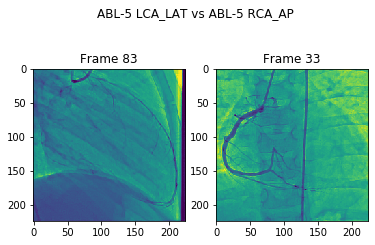

In [11]:
for batch_index_a, sequences_a in enumerate(test_loader):
    name_a = sequences_a[1][0]
    sequences_a = sequences_a[0][0]
    for batch_index_b, sequences_b in enumerate(test_loader):
        name_b = sequences_b[1][0]
        sequences_b = sequences_b[0][0]
        if name_a in selected_paths and name_b in selected_paths[name_a]:
            print(name_a, name_b)
            comparison_save_path = test_folder_path + f"\\comparisons\\{name_a}\\{name_b}\\pathfinding"
            if not os.path.isdir(comparison_save_path):
                os.makedirs(comparison_save_path)
            for pair_index, pair in enumerate([x[0] for x in selected_paths[name_a][name_b]]):
                plt.subplot(1, 2, 1)
                plt.imshow(sequences_a[pair[0], -1])
                plt.title(f"Frame {pair[0]}")
                plt.subplot(1, 2, 2)
                plt.imshow(sequences_b[pair[1], -1])
                plt.title(f"Frame {pair[1]}")
                plt.suptitle(f"{name_a} vs {name_b}")
                plt.savefig(comparison_save_path + f"\\{pair_index}.png")